In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import pickle
import pandas as pd

tf.compat.v1.disable_eager_execution()

# Introduction


In this notebook we will be learning how to do 4 tasks with Tensorflow/Keras:
1. Train a deep learning model using transfer learning on the German Traffic Sign Recognition Dataset GTSRB data set.
2. Implement 4 different white-box evasion attacks againts the model we trained, comparing their performances at different perturbation(ε) values
3. Implement a targeted white-box evasion attack using one of the attacks we have already implemented.
4. Implement a adversarial trainer defense for your model.

Each of theses tasks will be split up into their own sections with detailed descriptions of the methods used to implement each task. The goal of this notebook is to give you a beginners guide to techniques used in the adversarial machine learning field. You should be able to use what you've learned here to implement other attacks or defenses. Much of the machine learning field is rooted in research and most of the new machine learning and adversarial techniques are first published as papers. I highly suggest you go to the [arxiv][arxiv] website and check out the papers there. They are free to access and provide a great resource for those interested in the field.




### Requirments
This notebook relies on several packages to function.

Please install the following. Note: Please check the revision date on each of the links as they may be out of date

- Tensorflow 2.0 [Link][TFLOW]
- Numpy [Link][Numpy]
- MatPlotLib [Link][Plot]
- Pandas [Link][PANDA]
- h5py format [Link][h5]
- Adversarial Robustness ToolBox [Link][ART].

[//]: #
   [h5]:         <https://pypi.org/project/h5py/>
   [arxiv]: <https://arxiv.org/list/cs/recent>
   [TFLOW]: <https://www.tensorflow.org/install> 
   [Numpy]: <https://pypi.org/project/numpy/>
   [PANDA]: <https://pypi.org/project/pandas/>
   [Plot]: <https://pypi.org/project/matplotlib/>
   [ART]: <https://github.com/Trusted-AI/adversarial-robustness-toolbox>
    

    



# Part 1: Train a deep learning model using transfer learning

In this section we will be training a deep learning model using transfer training. Our goal with this model is to create an image classifier for our GTSRB dataset. The model we will be transfer training is the VGG16 model. This model is a convolutional network that was built for image classification and detection of 1000 image classes. The model has these layers as its architecture:

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg "Logo Title Text 1")

The concept behind transfer learning is rather simple. We can take a pre-existing model and train it on a task that is similar to what is was originally built to do. Since the VGG16 model was used for image classification and our goal is to make an image classifier, this should work out well. 


We want at least a 95% classification accuarcy when we test our model.

To complete this section we will follow these steps:
- Read in and normalize the GTSRB dataset to create a training, validation, testing set of images and labels.
- Tune hyperparameters for our model training.
- Build a callback function to prevent overfitting.
- Build a deep learning GTSRB classifier from VGG16 using transfer learning.
- Save the model to a hd5 file.
- Plot the history data.



# Reading in the dataset

Our dataset is in the form of pickle files. This is a format similar to JSON and we can access it similarly. 
The [Adversarial ML traffic sign][adv] github provides a function for loading the data in the util folder. Conceptually the data is loaded by accessing fields in the pickle file via key value pairs, and the data is read in. The data is first turned to grayscale before being normalized to be between 0-1. After this function is run we will have our training, validation, and testing data prepared. Other datasets you will encounter will do things differently. If you create your own, Keras has [documentation][gen] for how to do this. 


[//]: #

   [adv]: <https://github.com/inspire-group/advml-traffic-sign>
   [gen]: <https://keras.io/api/preprocessing/image/>


In [2]:
# Path to the directory containing the project files (IF BROKEN CHANGE THIS PATH TO THE DIRECTORY ON YOUR COMPUTER)
PROJECT_ROOT_DIR = os.getcwd() + '/'

# Path to the directory containing the dataset relative to project file
DATA_DIR = 'GTSRB_dataset/'

#path to the directory you want to use for saving models relative to the project file
MODEL_DIR = 'Best_models/'

In [3]:
# Funciton for loading the dataset
# Code from advml-traffic-sign (https://github.com/inspire-group/advml-traffic-sign)
def load_dataset_GTSRB(n_channel=3, train_file_name=None):
    """
    Load GTSRB data as a (datasize) x (channels) x (height) x (width) numpy
    matrix. Each pixel is rescaled to the range [0,1].
    """

    def load_pickled_data(file, columns):
        """
        Loads pickled training and test data.

        Parameters
        ----------
        file    : string
                          Name of the pickle file.
        columns : list of strings
                          List of columns in pickled data we're interested in.

        Returns
        -------
        A tuple of datasets for given columns.
        """

        with open(file, mode='rb') as f:
            dataset = pickle.load(f)
        return tuple(map(lambda c: dataset[c], columns))

    def preprocess(x, n_channel):
        """
        Preprocess dataset: turn images into grayscale if specified, normalize
        input space to [0,1], reshape array to appropriate shape for NN model
        """

        if n_channel == 3:
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
        else:
            # Convert to grayscale, e.g. single Y channel
            x = 0.299 * x[:, :, :, 0] + 0.587 * x[:, :, :, 1] + \
                0.114 * x[:, :, :, 2]
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
            x = x[:, :, :, np.newaxis]
        return x

    # Load pickle dataset
    if train_file_name is None:
        x_train, y_train = load_pickled_data(
            PROJECT_ROOT_DIR + DATA_DIR + 'train.p', ['features', 'labels'])
    else:
        x_train, y_train = load_pickled_data(
            PROJECT_ROOT_DIR + DATA_DIR + train_file_name, ['features', 'labels'])
    x_val, y_val = load_pickled_data(
        PROJECT_ROOT_DIR + DATA_DIR + 'valid.p', ['features', 'labels'])
    x_test, y_test = load_pickled_data(
        PROJECT_ROOT_DIR + DATA_DIR + 'test.p', ['features', 'labels'])

    # Preprocess loaded data
    x_train = preprocess(x_train, n_channel)
    x_val = preprocess(x_val, n_channel)
    x_test = preprocess(x_test, n_channel)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [4]:
# Load the images and labels. These images are RGB so we have 3 channels
imgs_train, labels_train, imgs_val, labels_val, imgs_test, labels_test = load_dataset_GTSRB(n_channel=3)

# Reading in the human readable label names

We also read in the sign names from the CSV file. We do this so we can get a name for the class label we receive when we classify an image. 

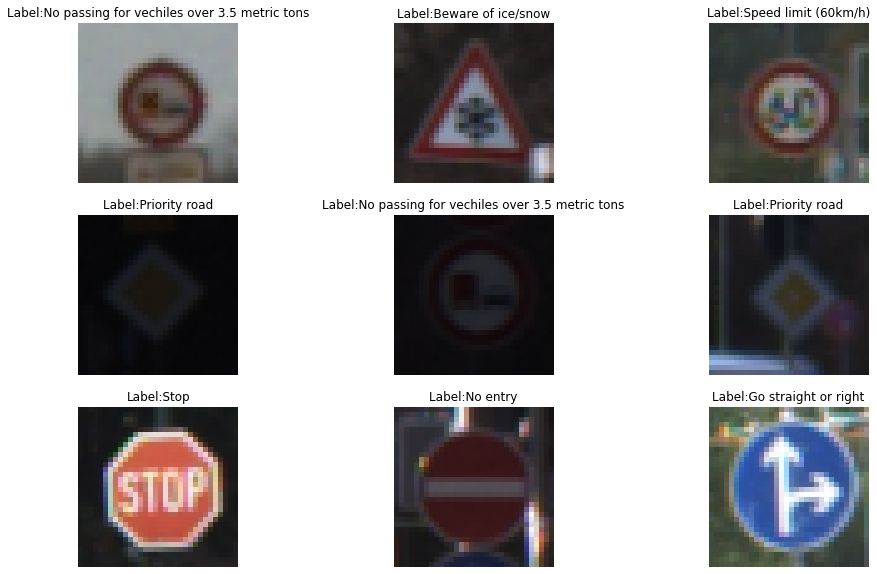

In [5]:
# Read the sign names
signnames = pd.read_csv(PROJECT_ROOT_DIR + 'GTSRB_dataset/signnames.csv').values[:, 1]

# Plot a few images to check if the data makes sense (note that the quality of some of the images is pretty low)
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]])
    plt.title('Label:' + str(signnames[labels_train[i[0]]]))
    plt.axis('off')

# Double check our dataset for sanity

The shape of our data can give us an idea of what kind of images we are working with.

Looking at the training data images.

                             Number of color channels
                             ^
                             |
                           Y axis number of pixels 
                           ^ |
                           | |
                        X axis number of pixels 
                        ^  | | 
                        |  | |
                   Number of images in the set 
                   ^    |  | | 
                   |    |  | |

Images train shape: (34799, 32, 32, 3) - Labels train shape: (34799,)


Our labels should match how many images we have, which it does. It looks like all of our data is well formed, now we can go onto the next step.


In [6]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(imgs_train))
print('Min pixel value', np.min(imgs_train))
print('Average pixel value', np.mean(imgs_train))
print('Data type', imgs_train[0].dtype)

Images train shape: (34799, 32, 32, 3) - Labels train shape: (34799,)
Images validation shape: (4410, 32, 32, 3) - Labels validation shape: (4410,)
Images test shape: (12630, 32, 32, 3) - Labels test shape: (12630,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.3242268
Data type float32


# Hyper parameter tuning.

Hyper parameters are the knobs we can turn on our model. 

The main parameters i will go over are Number of Epochs,learning rate(LR), Restore Best Weights(RBW) and patience)

- Number of Epochs: The integer number of times we are send the training data through our model. Depending on the application, dataset size, type of dataset, architecture of the model, and a bunch of other factors you may the number of epochs can range from as little as 2 or 3 epochs to train your model to possibly thousands. NOTE: it is not always best to train for large number of epochs due to overfitting. I will discuss how to prevent this in the next subsection.
- Learning rate: This determines the probability from [0,1] that our model updates the weights in a node. Generally this is a small number like 1E4 or similar. The lower this rate is, the more epochs are usually needed and the opposite is true for large learning rates.
- Restore best weights : This is a boolean parameter for the callback function that will be looked at next that tells our callback to restore the weights that gave the best score based on our monitoring parameter. NOTE: this only happens when the callback is actived. If you go through training without hitting the callback then the most recent weights will be used.
- Patience: This integer parameter is the number of epochs that we wait without improvement on the monitoring parameter before our callback is activated.


I will also note the NUM_LABELS number is from the number of classificaiton classes for our dataset. This will need to match your dataset classes if you use this notebook for something else

In [7]:
# Set constants (GTSRB)
NUM_LABELS = 43                             # Number of labels or classes for classification 
BATCH_SIZE = 128                            # Size of batch
HEIGHT = 32                                 # Height of input image
WIDTH = 32                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 43                             # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 50                             # Number of epoch to train
LR = 0.0002                                 # Learning rate
RBW = True #restore best weights
PATIENCE = 5# how many epochs between improvements

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)

# Callback function to prevent overfitting

The callback we are using is the early stopping callback. This stops the training if there are no improvements to the monitored value. In our case we use validation loss as the metric to determine this. Validation loss is typically used  as the window into our model to determine its performance.

If our callback is activated we want to restore the best weights because in the case of the callback activating we know we were not improving and got stuck in a valley or saddle point in our optimization surface. We want the best weights before this happened. More information can be found [here][call]

<code>callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=RBW)]</code>
              
[//]: #

   [call]: <https://keras.io/api/callbacks/>


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=RBW)]

# Setting up labels

Most models expect a onehot encoded labels, which just means converting the 1d label array into 2d for each class.
Keras provides functionality for this. NOTE: Make sure you dont clobber the original labels. If you do you might end up in a situation where you have run the cell block more than once and your shapes are worong. This can be a hard bug to spot.

In [9]:
from tensorflow.keras.utils import to_categorical

#Convert the labels to one-hot encoding (to input to the models)

#make a copy of 1000 test images before we encode for adversarial testing.
imgs_adv = imgs_test[0:1000,:,:,:].copy()
labels_adv = labels_test[0:1000].copy()




labels_train_cat = to_categorical(labels_train, NUM_LABELS)
labels_test_cat = to_categorical(labels_test, NUM_LABELS)
labels_val_cat = to_categorical(labels_val, NUM_LABELS)

#for testing adversarial inputs
labels_adv_cat = to_categorical(labels_adv,NUM_LABELS)

print('Labels train shape: {}'.format(labels_train.shape))
print('Labels train catagorical shape: {}\n'.format(labels_train_cat.shape))
print('Labels Adver shape: {}'.format(labels_adv.shape))
print('Labels Adver catagorical shape: {}'.format(labels_adv_cat.shape))

print('Imgs Adver shape: {}'.format(imgs_adv.shape))



Labels train shape: (34799,)
Labels train catagorical shape: (34799, 43)

Labels Adver shape: (1000,)
Labels Adver catagorical shape: (1000, 43)
Imgs Adver shape: (1000, 32, 32, 3)


# Build our deep learning model

The model we are creating is the VGG16 model. This model can be accessed though tf.keras.applications.MODELNAME which will download the model for you. A list of available models that you can use can be found [here.][model]

We can think of transfer learning as changing the input end of the model to match our image size, and chopping off the classification output end of the model and replacing it with our own classification layers.

In order to perform transfer learning we need to set three parameters.

- Remove Top: We set this to true, so that we can take the computation layers of the model and remove the 3 outer most dense and softmax layers. If you look at the image at the top of the notebook, you can see what layers are being removed. With these layers gone we will need to create our own classification layers. 
- Weights: We need to set the weights parameter, and we want to use imagenet for this. This is a set of parameter allows the use of pre trained weights to be loaded into the model for better training performance. imagenet is a image recognition weightset and should be good for our model. You can set this to none if you wish but performance may vary.
- Input_shape: this is the size of our images(which for us is 32x32). We need to set this because we removed the top of the model. 


Typically the output layers of a model consists of sever fully connected dense layers and an argmax or sofmax layer to give you a classification. The argmax/sofmax node number should match your output classes.


We compile the model using ADAM as our loss optimizer and use categorical_crossentropy as our loss function. We monitor accuracy as our metric. A list of loss optimizers can be found [here][adam]




[//]: #

   [model]: <https://keras.io/api/applications/>
   [adam]: <https://keras.io/api/optimizers/>


In [37]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam



#create our model
def build_model():
    #create VGG16 model with properties we want.
    base_model = tf.keras.applications.VGG16(include_top=False,
                                    weights="imagenet",
                                    input_shape=INPUT_SHAPE)

    #create fully connected layers
    #by not including the top we need to create these layers ourselves
    #input and output layers
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully-connected layer
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer with 43 classes
    predictions = Dense(OUTPUT_DIM, activation='softmax', name ='softmax')(x)

    # The model 
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])
    
 
    
    return model

    

# Training our model

Now that we have compiled the model, we can begin training. The fitness function has a number of parameters that we use and i will define them below. There are more parameters than what i define and their usage can be found [here][fit]


model.fit parameters:

- x: Our training image set
- y: Our training labels that have been one-hot encoded(catagorical)
- batch size: number of samples per gradient update. This effects performce on GPU based applications. 
- Epochs: number of times our model is fed the training data
- validation_data: a tuple of validation images and labels. NOTE: you can use the validation_split parameter if you do not have a validation dataset already.
- Verbose: how noisy the output is in the notebook.
- Callbacks: any user defined callbacks to be run during training. We made one earlier for early stopping. 


For evaluating our performance we can just use the evaluate function. It takes the images and labels as parameters.
we want to get atleast 95% classification accuarcy on the test set. If we dont, we can tune some of the hyper parameters to try and get it to that accuarcy. Due to the stochastic nature of ML small tuning is important and can take time to get right.

[//]: #

   [fit]: <https://keras.io/api/models/model_training_apis/>




In [49]:
# Training the model 

model = build_model()

t = datetime.datetime.now()

#fit the model
history = model.fit(x= imgs_train,
    y= labels_train_cat,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    # monitoring validation loss and metrics
    validation_data=(imgs_val, labels_val_cat),
    verbose=1,
    callbacks=callbacks)

print('Training time: %s\n' % (datetime.datetime.now() - t))



# Evaluate on train,validation,test images
t = datetime.datetime.now()
evals_test = model.evaluate(imgs_test, labels_test_cat)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = model.evaluate(imgs_val, labels_val_cat)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = model.evaluate(imgs_train, labels_train_cat)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))








Train on 34799 samples, validate on 4410 samples
Epoch 1/50
34799/34799 [==============================] - 9s 271us/sample - loss: 1.1008 - accuracy: 0.6680 - val_loss: 0.2962 - val_accuracy: 0.9220
Epoch 2/50
34799/34799 [==============================] - 9s 250us/sample - loss: 0.1331 - accuracy: 0.9606 - val_loss: 0.2214 - val_accuracy: 0.9501
Epoch 3/50
34799/34799 [==============================] - 9s 249us/sample - loss: 0.0670 - accuracy: 0.9830 - val_loss: 0.1578 - val_accuracy: 0.9558
Epoch 4/50
34799/34799 [==============================] - 9s 257us/sample - loss: 0.0370 - accuracy: 0.9902 - val_loss: 0.2131 - val_accuracy: 0.9562
Epoch 5/50
34799/34799 [==============================] - 9s 253us/sample - loss: 0.0266 - accuracy: 0.9930 - val_loss: 0.1648 - val_accuracy: 0.9651
Epoch 6/50
34799/34799 [==============================] - 9s 250us/sample - loss: 0.0252 - accuracy: 0.9937 - val_loss: 0.1336 - val_accuracy: 0.9776
Epoch 7/50
34799/34799 [===========================

# Saving our model

If our classification accuarcy is adequate we should save our model so that we dont lose it. Depending on training time, you may not want to have to wait for another model to train. When another model is trained theres no gurantee it will work as well as your old one either. Better safe than sorry.

You can save the model by going <code>model.save(filepath)</code>

you can load the model by <code>tf.keras.models.load_model(filepath)</code>.


If you want to save the history of the model training you can do so with this numpy call:

<code>np.save(PROJECT_ROOT_DIR + MODEL_DIR + "trainVGGHistoryDict.npy", history.history) </code>

you can load it with this call:

<code> np.load(PROJECT_ROOT_DIR + MODEL_DIR + "trainVGGHistoryDict.npy",allow_pickle=True).item() </code>


In [10]:
from tensorflow.keras.models import load_model

#save the model
model.save(PROJECT_ROOT_DIR + MODEL_DIR +'VGG_best.h5')

#save our history so we dont lose it.
np.save(PROJECT_ROOT_DIR + MODEL_DIR + "trainVGGHistoryDict.npy", history.history)

#load our already trained model
model = load_model(PROJECT_ROOT_DIR + MODEL_DIR +'VGG_best.h5')





# Graphing the history 

After we are done training we should graph the history to see how our model did.

In general, a well trained model will have training and validation accuarcy  rise toward the 90% range as the training epochs go on. With the training and validation loss you want to see your loss continually go down. This indicates getting closer to the ground truth and a more accurate model. When the validation loss rises, this is usually indicative of overfitting.

You can see in our graph the validation loss began to rise around the 10 epoch mark, so we know we began to lose our generalization performance and where starting to overfit on the training data. However, we used a callback so we had an early stop to prevent training any longer and we were able to resotre our best weights giving us the best performance of our model.

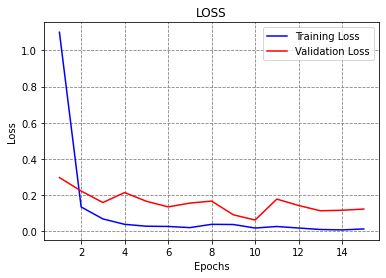

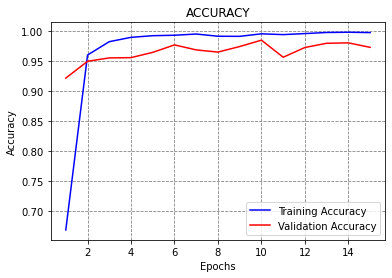

In [51]:

history = np.load(PROJECT_ROOT_DIR + MODEL_DIR + "trainVGGHistoryDict.npy",allow_pickle=True).item()


# Plot the loss and accuracy
train_loss = history['loss']
val_loss = history['val_loss']
acc = history['accuracy'] 
val_acc = history['val_accuracy']


epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')


axes = plt.gca()

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()



# Part 2: Implement 4 different white-box evasion attacks on our model

In this section we will be apply 4 different white-box evasion attacks from the Adversarial Robustness Toolbox.

The 4 attacks we will be using and their documentation are:

- Fast Gradient Sign Method(FGSM): [Documentation][FGSM]
- Projected Gradient Descent(PGD): [Documentation][PGD]
- DeepFool(DF):                    [Documentation][DFool]
- NewtonFool(NF):          [Documentation][NFool]


The goal of all of these attacks are to cause the model to misclassify an input image. Each one similar parameters in their attack objects.

FGSM and PGD use:

- estimator: This is our model that has been converted to a special ART classifier
- Epsilon: This is the amount of perturbation we want to apply as a number out of 255. so Epsilon/255 with 1 being maximum perturbment and 1 being very small amounts. When we are doing adversarial attacks its important to think about how the data will look after we have altered it. A high perturbment may misclassify well, but if it super noticable by a human its not a very good adversarial attack. You should shoot for an Epsilon value of around 8 or less.
- Targeted: this is a flag that lets you specify a target label to try and force a misclassification to. This can be useful if you know the output classes and want a specific one no matter the input image.
- Batch size: how many images are perturbed at a time. This can help increase computation speed on GPU's.

- max iters (SPECIFIC TO PGD): Maxiumum number of iterations for perturbations. This determines the number of rounds and therefore how long it takes to generate adversarial images.

DeepFool Uses:

- Classifier This is our model that has been converted to a special ART classifier
- max_iter: Maxiumum number of iterations for perturbations. This determines the number of rounds and therefore how long it takes to generate adversarial images.
- Epsilon: This is the amount of perturbation we want to apply as a number out of 255. so Epsilon/255 with 1 being maximum perturbment and 1 being very small amounts.


NewtonFool Uses:

- Classifier This is our model that has been converted to a special ART classifier
- max_iter: Maxiumum number of iterations for perturbations. This determines the number of rounds and therefore how long it takes to generate adversarial images.
- Eta: This is the amount of perturbation we want to apply as a number out of 255. so Eta/255 with 1 being maximum perturbment and 1 being very small amounts.
- Batch size: how many images are perturbed at a time. This can help increase computation speed on GPU's.

Once you have created the attack object you can then generate images using the attackObj.generate function. For FGSM and PGD they take these parameter:

- x: The images you want to attack
- y: labels you are targeting NOTE: ONLY GIVE THIS PARAMETER IF TARGETEDF WAS TRUE IN THE ATTACK OBJECT

For DeepFool and NewtonFool they take:
- x: The images you want to attack
- y: labels that go with the images passed as x.  NOTE: This is different than targeted attacks and are required for these attacks.


To complete this section we will follow these steps:

- Apply the 4 attacks over a range of epsilon values
- Graph our result and show what perturb images look like


[//]: #

   [FGSM]: <https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm>
    
   [PGD]: <https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd>
  
   [DFool]: <https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#deepfool>
   
   [NFool]: <https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#newtonfool>
   [ART]:   <https://github.com/Trusted-AI/adversarial-robustness-toolbox>


In [11]:
#perform adversiarial attacks such as Fast gradient and  ProjectedGradientDescent, DeepFool, NewtonFool
from art.estimators.classification import KerasClassifier,TensorFlowV2Classifier
from art.estimators import KerasEstimator
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent,NewtonFool,DeepFool
import sys

#returns the perturbed image set from  a Fast Gradient Sign Method attack and the 
#returns just the perturbed image set
#param1 Epsilon of the perturbation for the image. E/255
#param2 the model you intend to attack
#param3 image set to attack
#param4 is this attack targeted againts the labels?

def fgsm_attack(Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
     
    
    #to increase the miss identification, we make this attacked targeted againts the true labels.
    attackFgsm = FastGradientMethod(estimator=Classifier,
                                    eps=(Epsilon/255),
                                    targeted=Targeted)                                  
    
    #check our parameters and perform the proper actions
    #if we have labels and we are targeted we can generate the proper images
    if  Targeted == True and Labels is not None:
        return attackFgsm.generate(Imgs_Test,Labels) 
    
    #We just want to perturbe the image set without any targeting.
    elif Targeted == False:
        return attackFgsm.generate(Imgs_Test)
    
    #some form of parameter error
    else:
        print("make sure you have given the function: fgsm_attack a set of labels that have NOT been turned into catagorical if you are doing a targeted attack")
        print("Stopping program ...")
        sys.exit()

        
#returns the perturbed image set from  a Fast Gradient Sign Method attack and the 
#returns just the perturbed image set
#param1 Epsilon of the perturbation for the image. E/255
#param2 the model you intend to attack
#param3 image set to attack
#param4 is this attack targeted againts the labels?

def pgd_attack(Epsilon,Classifier,Imgs_Test,Targeted, Labels=None):
    
    attackPgd = ProjectedGradientDescent(estimator = Classifier,
                                         eps=(Epsilon/255),
                                         targeted=Targeted,
                                         batch_size =256)
    
    #check our parameters and perform the proper actions
    #if we have labels and we are targeted we can generate the proper images
    if Targeted == True and Labels is not None:
        return attackPgd.generate(Imgs_Test,Labels)
    
    #We just want to perturbe the image set without any targeting.
    elif Targeted == False:
        return attackPgd.generate(Imgs_Test)
    
    #some form of parameter error
    else:
        print("make sure you have given the function: pgd_attack a set of labels if you are doing targeted attacks")
        print("Stopping program ...")
        sys.exit()
        
        
def df_attack(Epsilon,Classifier,Imgs_Test,Labels=None):
    
    attackDF = DeepFool(classifier = classifier,
                          epsilon=Epsilon/255,
                          batch_size=256,
                          max_iter = 5)
    #check our parameters and perform the proper actions
    #if we have labels and we are targeted we can generate the proper images
    if Labels is not None:
        return attackDF.generate(Imgs_Test,Labels)
    
    #some form of parameter error
    else:
        print("make sure you have given the function: df_attack a set of labels")
        print("Stopping program ...")
        sys.exit()        
        
        
def nf_attack(Eta,Classifier,Imgs_Test,Labels=None):
    
    attackNF = NewtonFool(classifier = classifier,
                          eta=Eta/255,
                          batch_size=256,
                          max_iter = 10)
    #check our parameters and perform the proper actions
    #if we have labels and we are targeted we can generate the proper images
    if Labels is not None:
        return attackNF.generate(Imgs_Test,Labels)
    
    #some form of parameter error
    else:
        print("make sure you have given the function: nf_attack a set of labels")
        print("Stopping program ...")
        sys.exit()
         
def print_classification_acc(Classifier, nameOfDataSet,imgs,labels):
    x_test_robust_pred = np.argmax(Classifier.predict(imgs), axis=1)
    nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(labels, axis=1))


    print(nameOfDataSet + " Classification")
    print("Correctly Classified: {}".format(nb_correct_robust_pred))
    print("Incorrectly Classified: {}".format(len(imgs) -nb_correct_robust_pred))
    print("Percent Correct Classified: {}%\n".format((nb_correct_robust_pred/len(imgs)) *100))

# Apply the attack

We apply our attacks over a range of epsilon values and store the data we will need to analyze in the result section using the functions created in the block above. 

In [105]:
#List for plotting and storing images to display. 
fgsm_acc_list = []
fgsm_image_list =[]
fgsm_pred_list =[]
fgsm_pertb_list =[]

pgd_acc_list = []
pgd_image_list = []
pgd_pred_list = []
pgd_pertb_list = []

df_acc_list = []
df_image_list = []
df_pred_list = []
df_pertb_list = []

nf_acc_list = []
nf_image_list = []
nf_pred_list = []
nf_pertb_list = []

epsilon_list = [1/255,4/255,8/255,10/255,20/255]
    

classifier = KerasClassifier(model=model, clip_values=(0, 1))


for eps in epsilon_list:
    
    imgs_adv_fgsm = fgsm_attack(eps*255,classifier,imgs_adv,Targeted=False,Labels=labels_adv_cat)
    imgs_adv_pgd = pgd_attack(eps*255,classifier,imgs_adv,Targeted=False,Labels=labels_adv_cat)
    imgs_adv_df = df_attack(eps*255,classifier,imgs_adv,labels_adv_cat)
    imgs_adv_nf = nf_attack(eps*255,classifier,imgs_adv,labels_adv_cat)
    
    fgsm_image_list.append(imgs_adv_fgsm[0])
    pgd_image_list.append(imgs_adv_pgd[0])
    df_image_list.append(imgs_adv_df[0])
    nf_image_list.append(imgs_adv_nf[0])

    loss_test_fgsm, accuracy_test_fgsm = model.evaluate(imgs_adv_fgsm, labels_adv_cat)
    loss_test_pgd, accuracy_test_pgd = model.evaluate(imgs_adv_pgd, labels_adv_cat)
    loss_test_df, accuracy_test_df = model.evaluate(imgs_adv_df, labels_adv_cat)
    loss_test_nf, accuracy_test_nf = model.evaluate(imgs_adv_nf, labels_adv_cat)
    
    fgsm_acc_list.append(accuracy_test_fgsm)
    pgd_acc_list.append(accuracy_test_pgd)
    df_acc_list.append(accuracy_test_df)
    nf_acc_list.append(accuracy_test_nf)
    
    #predict first image
    prediction_fgsm = model.predict(imgs_adv_fgsm[0:1,:,:,:])
    prediction_pgd = model.predict(imgs_adv_pgd[0:1,:,:,:])
    prediction_df = model.predict(imgs_adv_fgsm[0:1,:,:,:])
    prediction_nf = model.predict(imgs_adv_pgd[0:1,:,:,:])
    
    fgsm_pred_list.append(prediction_fgsm.argmax(axis=-1))
    pgd_pred_list.append(prediction_pgd.argmax(axis=-1))
    df_pred_list.append(prediction_df.argmax(axis=-1))
    nf_pred_list.append(prediction_nf.argmax(axis=-1))
    


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

NewtonFool:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

NewtonFool:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

NewtonFool:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

NewtonFool:   0%|          | 0/4 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/4 [00:00<?, ?it/s]

NewtonFool:   0%|          | 0/4 [00:00<?, ?it/s]

# Results:

If we look at the graph, we can see that as perturbation increases the accuracy goes down dramatically. This is exactly what we want to see because the goal of these attacks are to cause missclassifications. overall it PGD performed best for our use case causing immediate loss in classification accuracy that continues as the epsilon value grows. Deep fool didnt work as well and appears to have not changed much with different perturbation levels.

FGSM performed similarly to PGD but less effective for the same epsilon values. NewtonFool performed similarly to Deep Fool not moving much when epsilon is changed.

For our convenience we plot a single image for all the epsilon values for all the attacks. Notice how some look very perturbed while others do not. This is the stealthiness aspect between each attack type

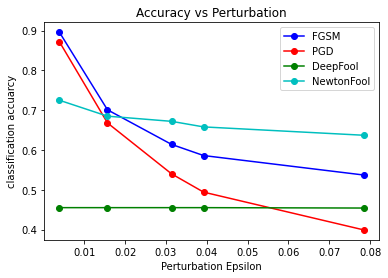

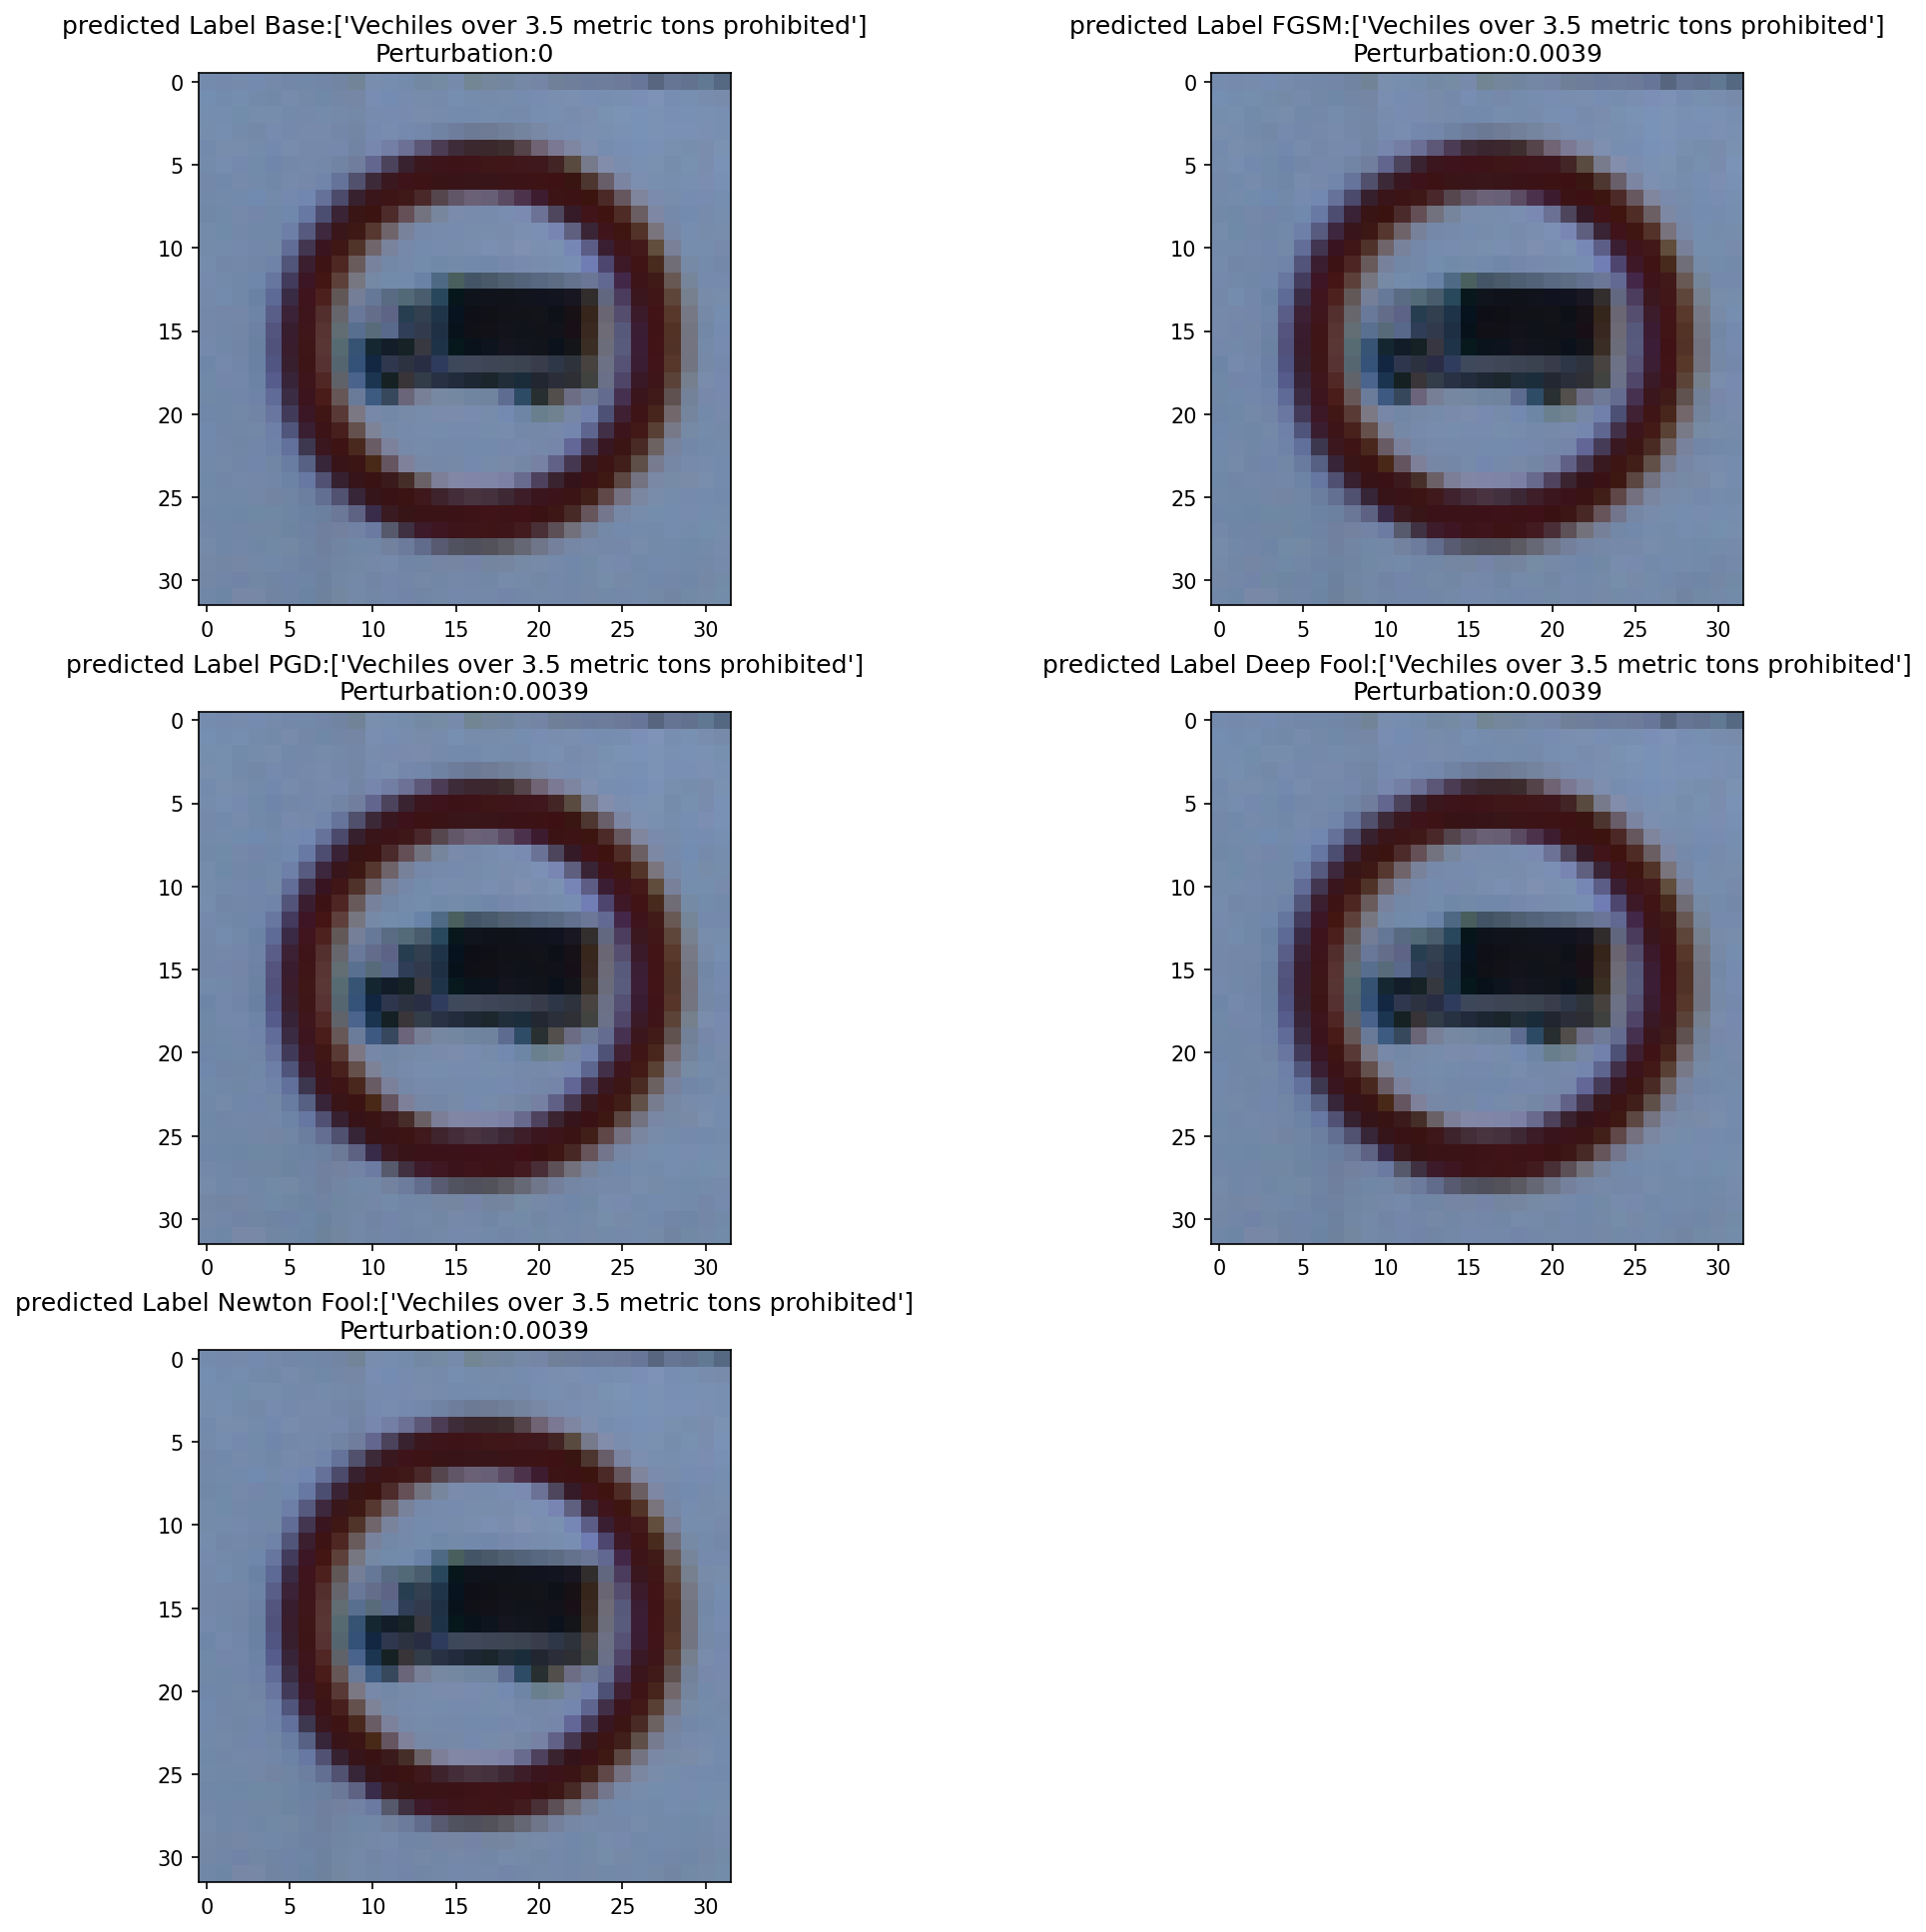

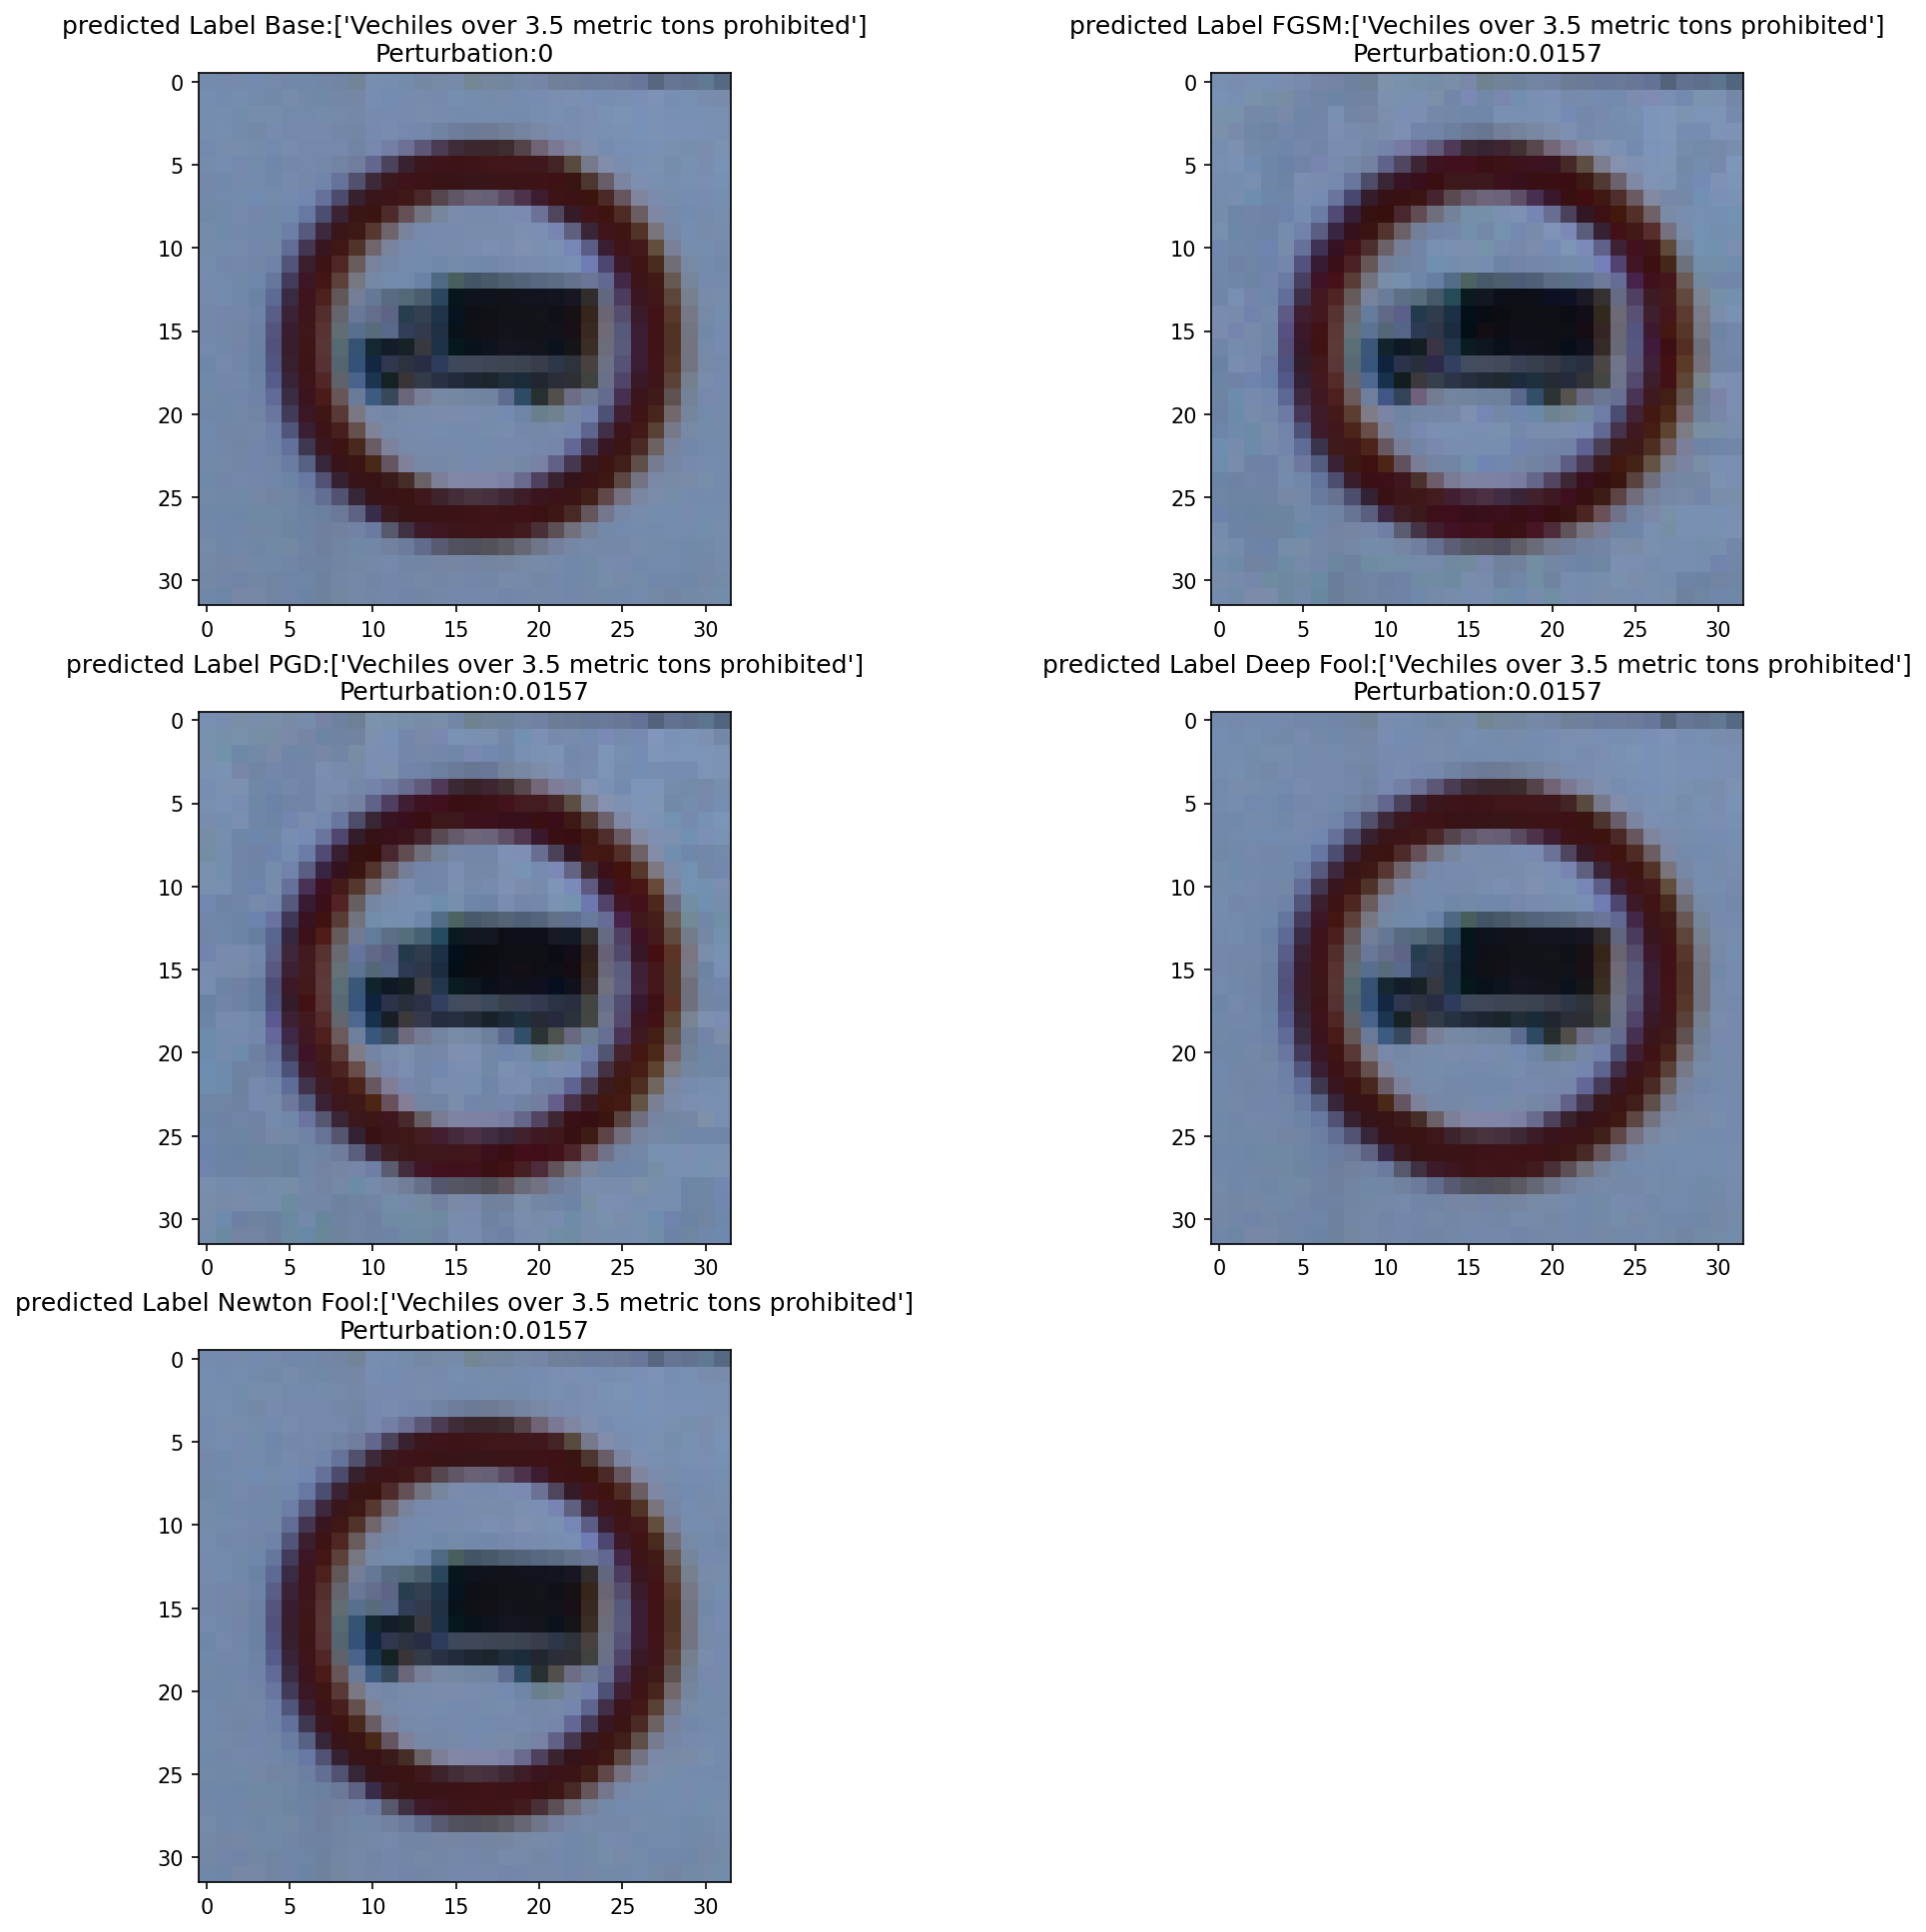

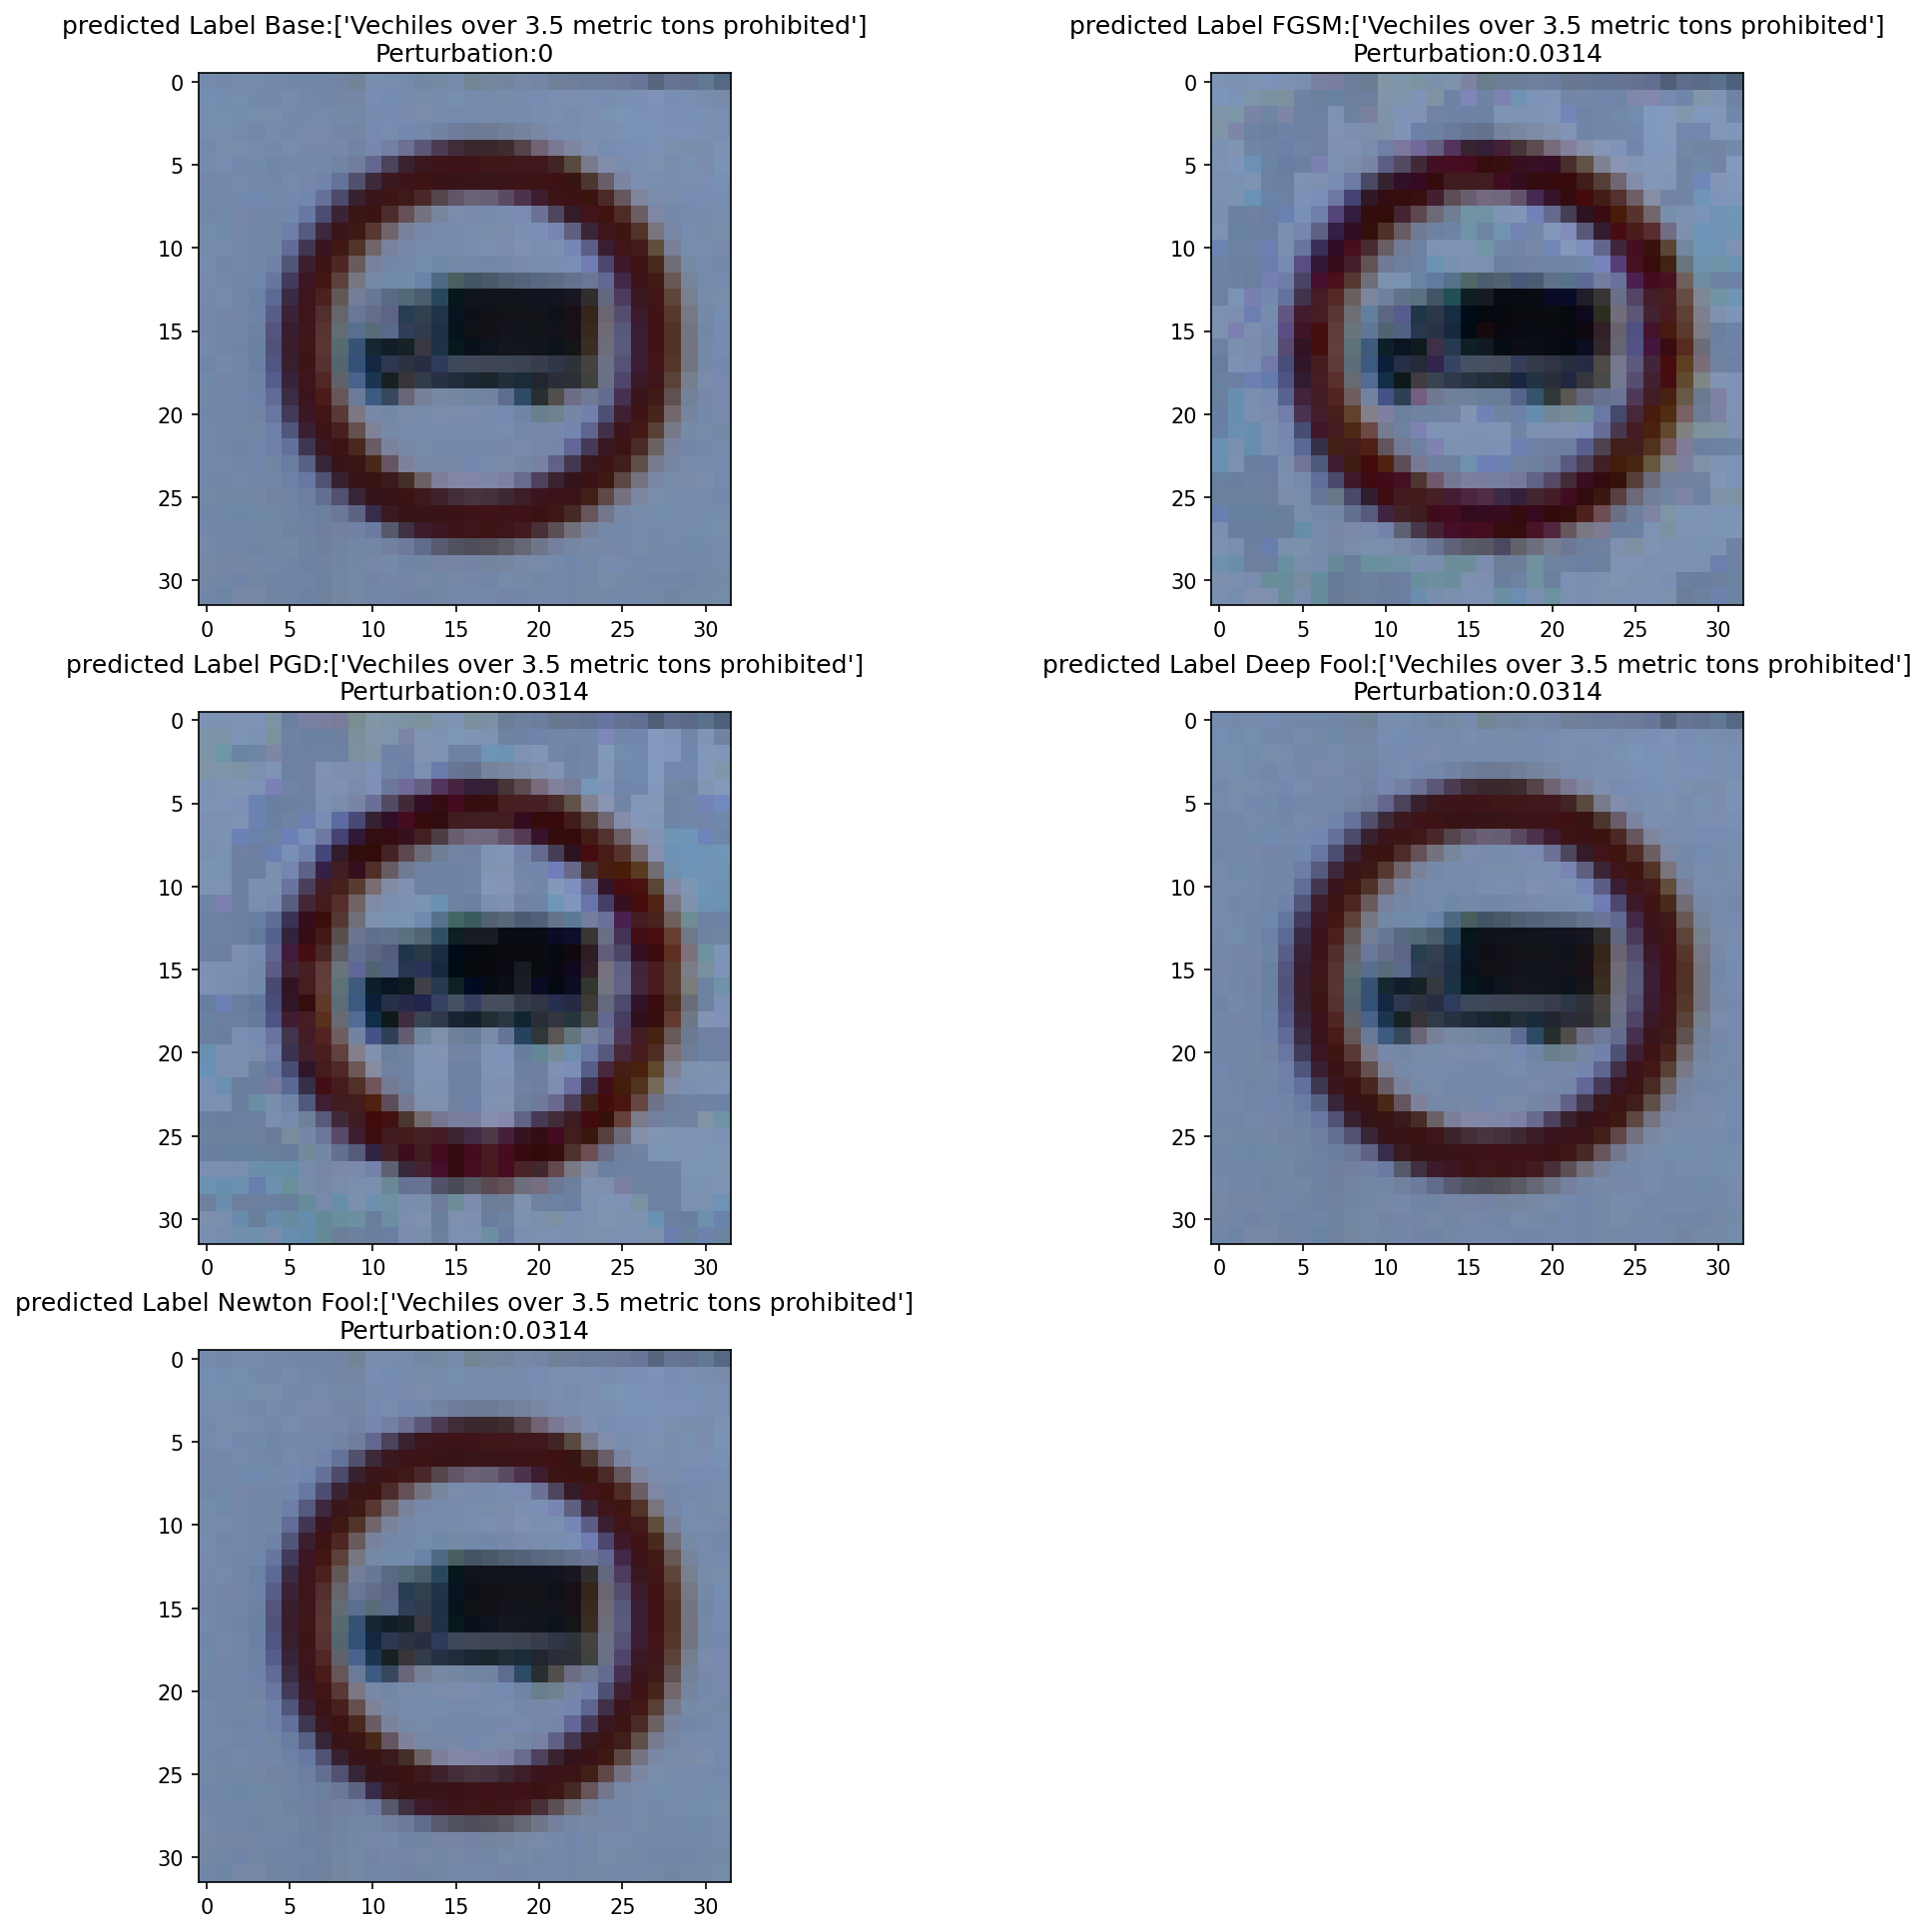

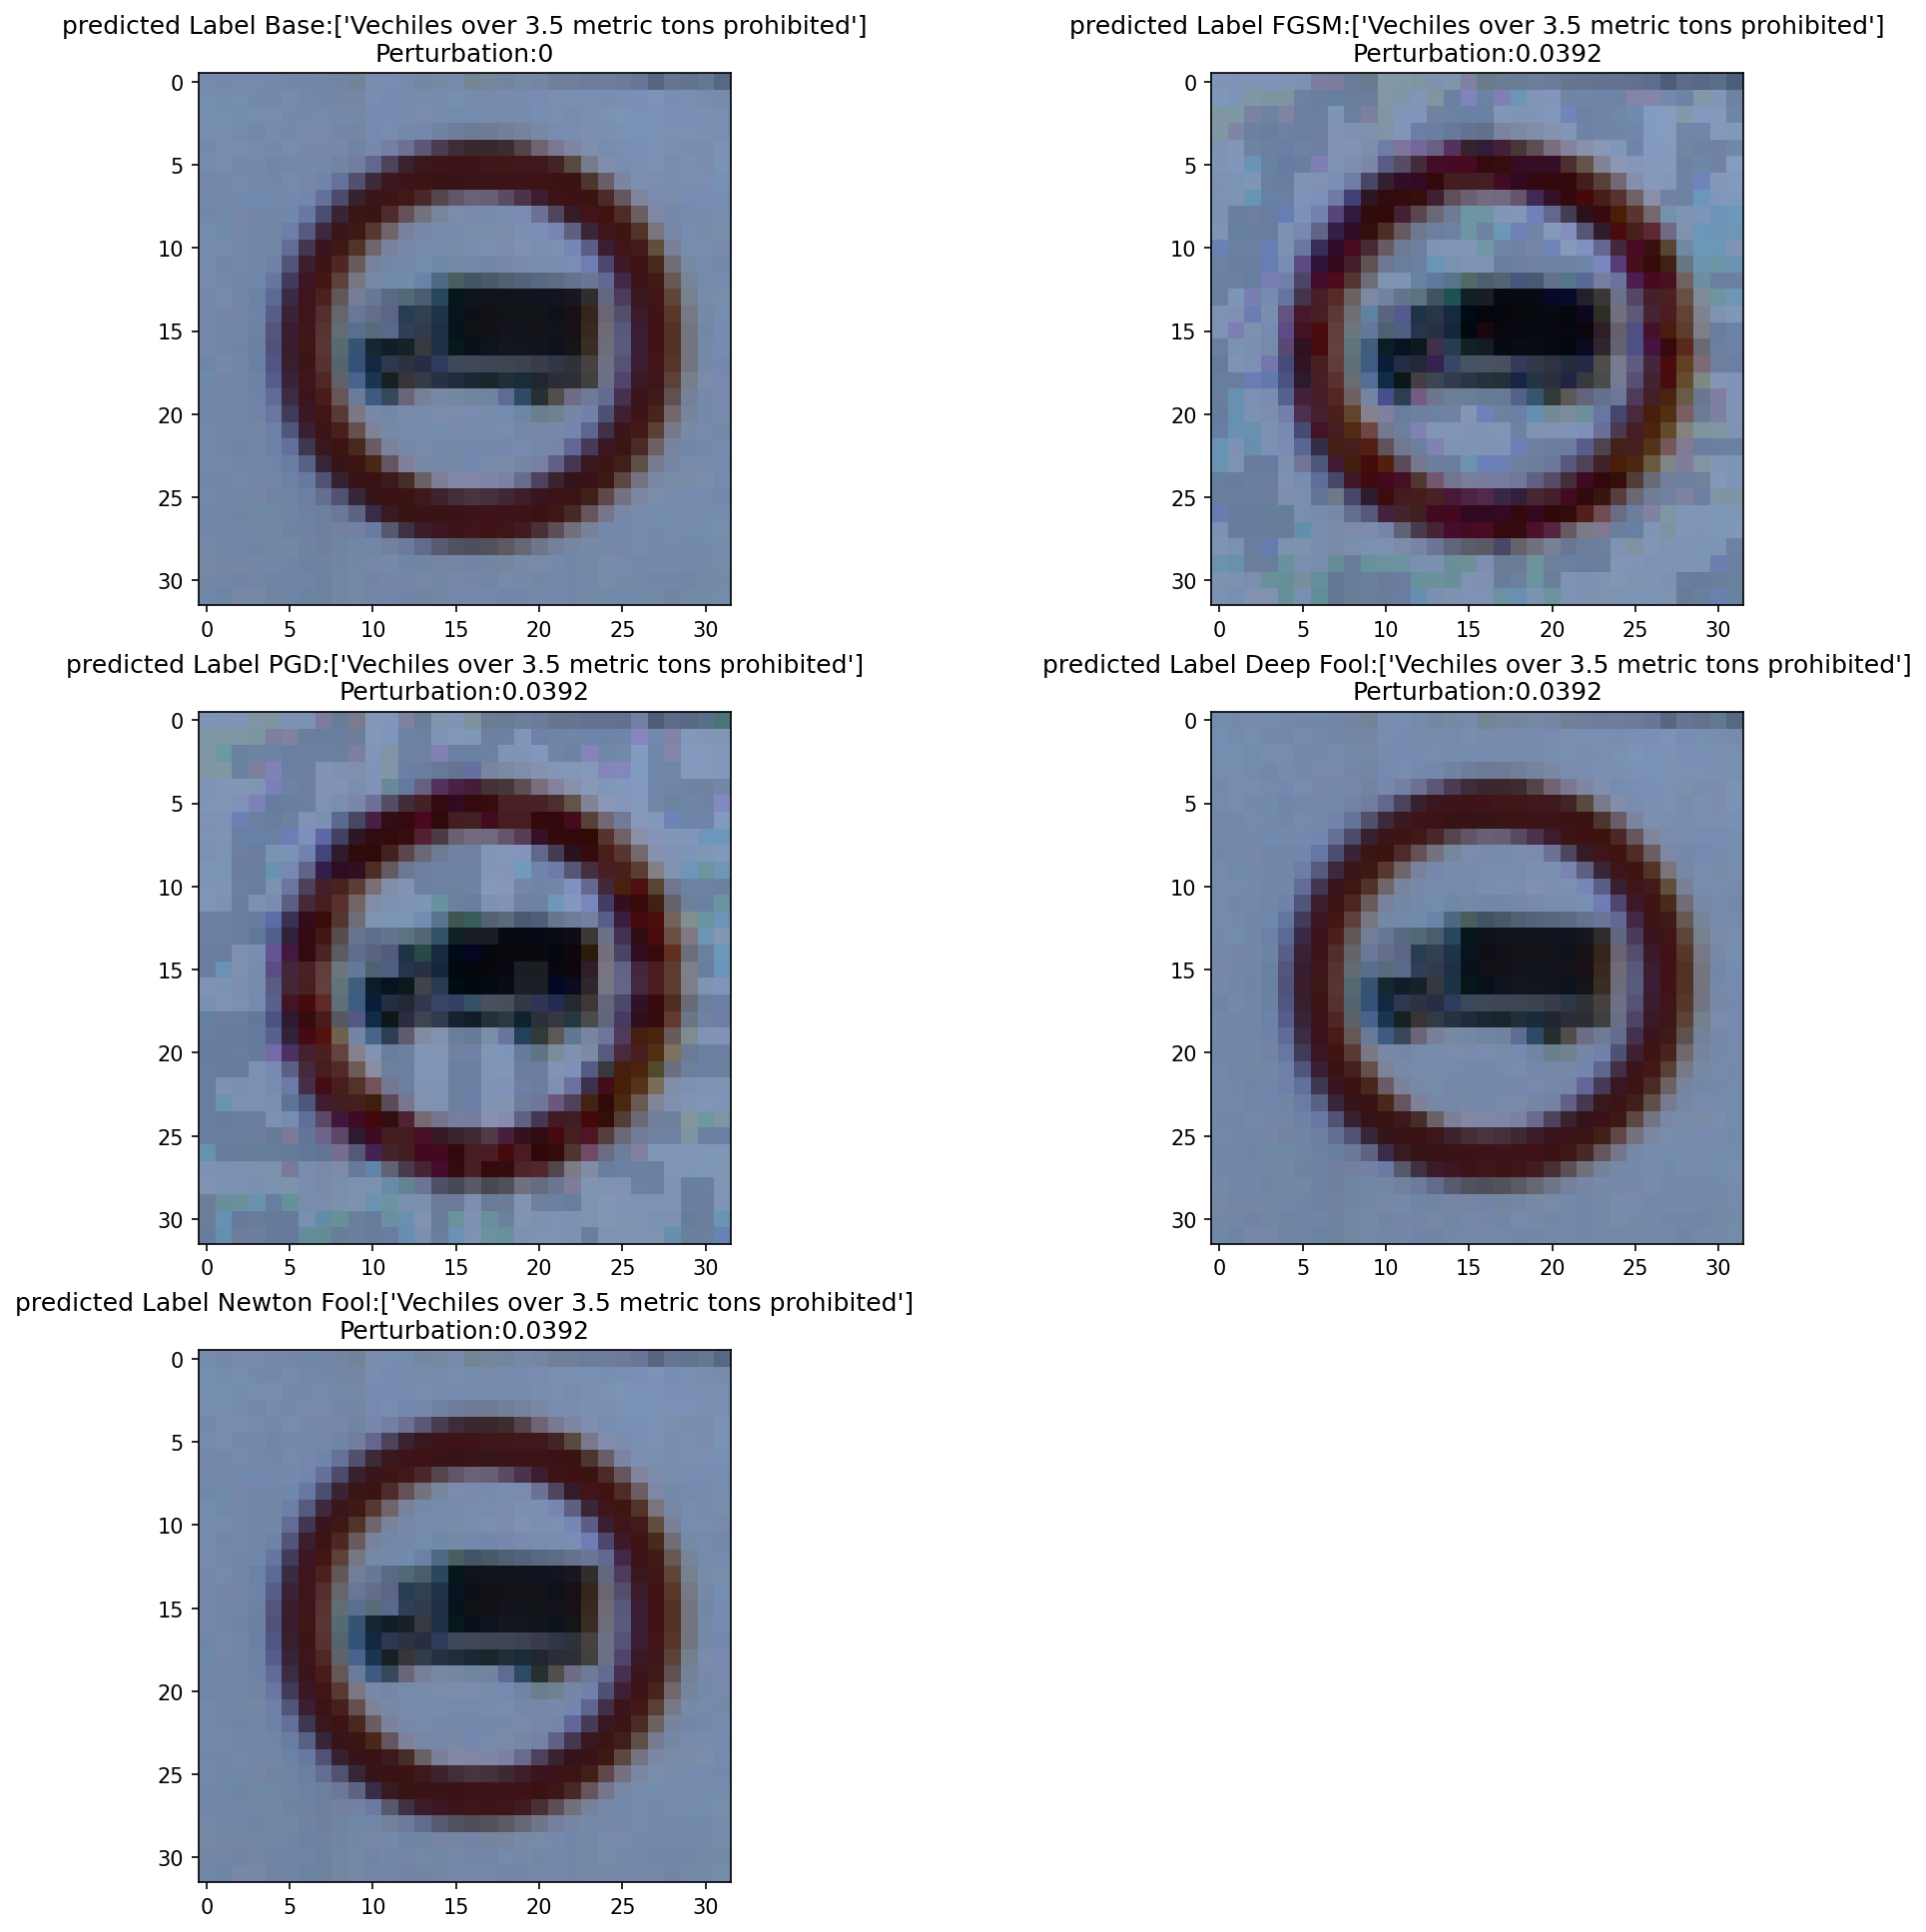

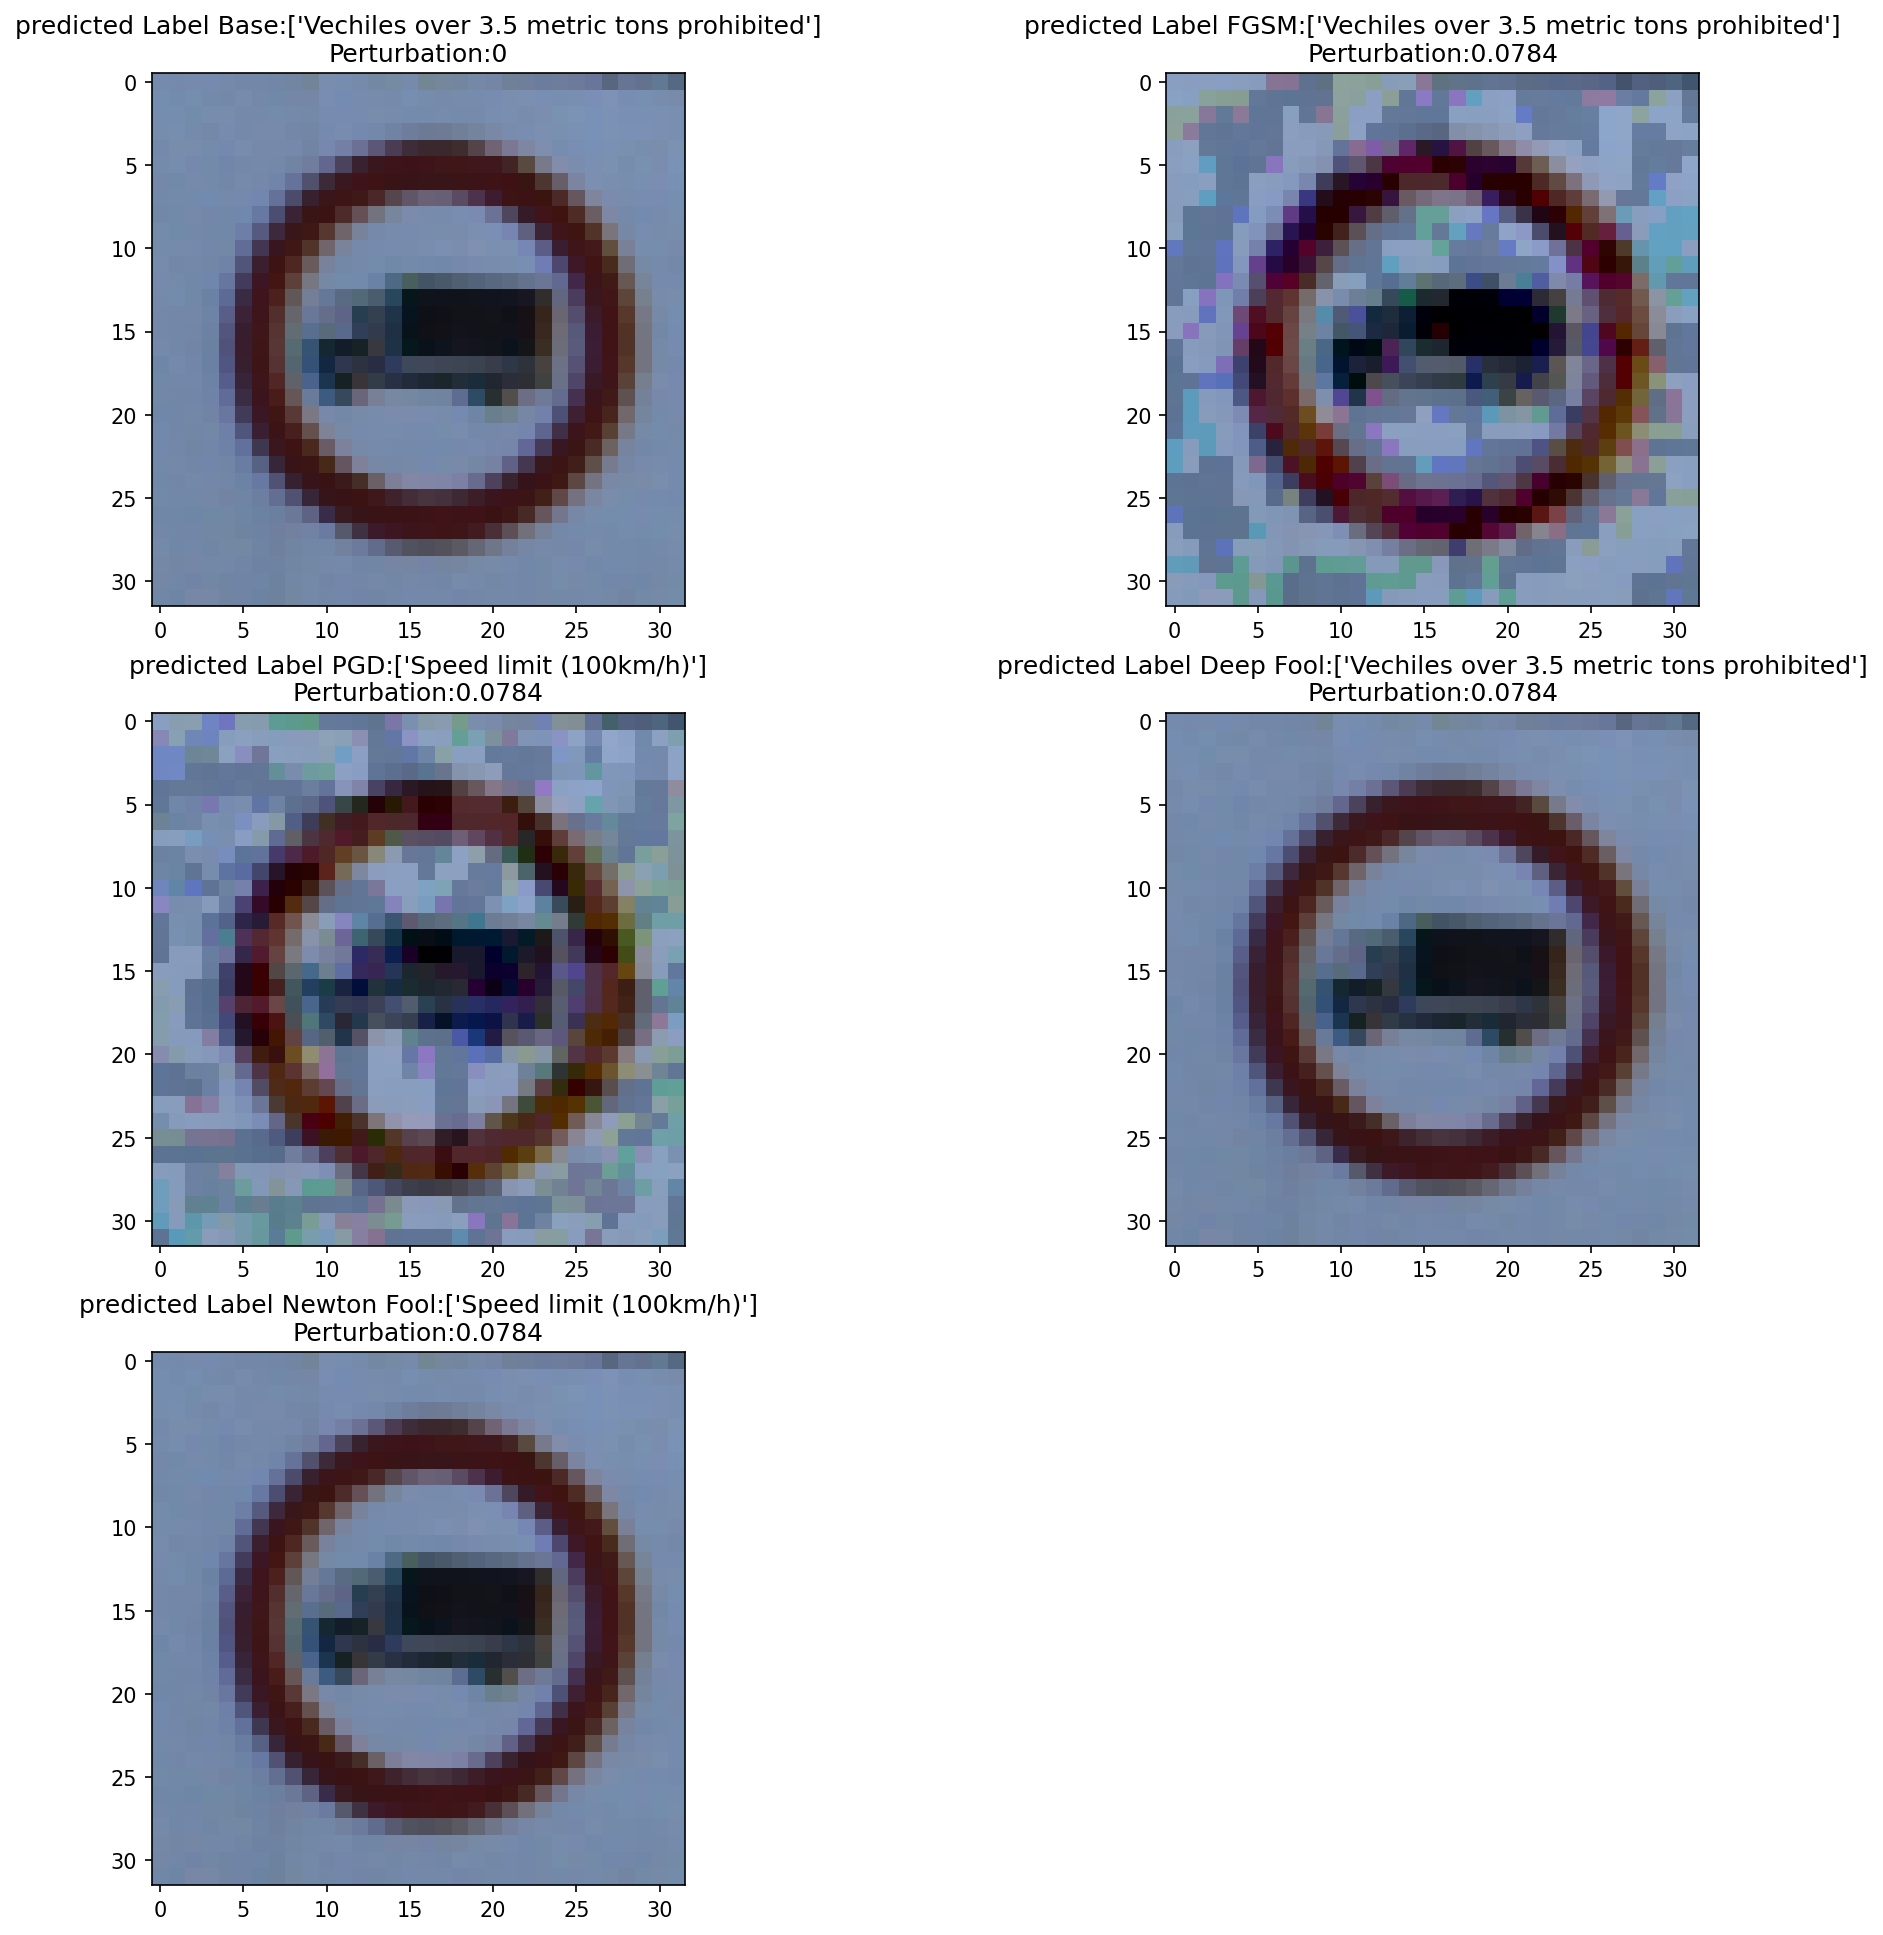

In [113]:

plt.plot(epsilon_list,fgsm_acc_list, 'b', label='FGSM',marker='o')
plt.plot(epsilon_list,pgd_acc_list, 'r', label='PGD',marker='o')
plt.plot(epsilon_list,df_acc_list, 'g', label='DeepFool',marker='o')
plt.plot(epsilon_list,nf_acc_list, 'c', label='NewtonFool',marker='o')


plt.legend()
plt.title('Accuracy vs Perturbation')
plt.xlabel('Perturbation Epsilon')
plt.ylabel('classification accuarcy')

plt.show()





def show_images(EpsilonIndex):
    plt.figure(figsize=(16, 16), dpi=150)
    
    plt.subplot(3,2,1)
    plt.title('predicted Label Base:' + str(signnames[fgsm_pred_list[EpsilonIndex]])+ '\n' + 'Perturbation:' + str(0))
    plt.imshow(imgs_test[0])

    plt.subplot(3,2,2)
    plt.title('predicted Label FGSM:' + str(signnames[fgsm_pred_list[EpsilonIndex]])+ '\n' + 'Perturbation:' + str(round(epsilon_list[EpsilonIndex],4)))
    plt.imshow(fgsm_image_list[EpsilonIndex])

    plt.subplot(3,2,3)
    plt.title('predicted Label PGD:' + str(signnames[pgd_pred_list[EpsilonIndex]])+ '\n' + 'Perturbation:' + str(round(epsilon_list[EpsilonIndex],4)))
    plt.imshow(pgd_image_list[EpsilonIndex])

    plt.subplot(3,2,4)
    plt.title('predicted Label Deep Fool:' + str(signnames[df_pred_list[EpsilonIndex]])+ '\n' + 'Perturbation:' + str(round(epsilon_list[EpsilonIndex],4)))
    plt.imshow(df_image_list[EpsilonIndex])

    plt.subplot(3,2,5)
    plt.title('predicted Label Newton Fool:' + str(signnames[nf_pred_list[EpsilonIndex]])+ '\n' + 'Perturbation:' + str(round(epsilon_list[EpsilonIndex],4)))
    plt.imshow(nf_image_list[EpsilonIndex])
    
    plt.show()


for i in range(0,len(epsilon_list)):
    show_images(i)






plt.show()

# Part 3: implement a targeted attack on our model

For this section we will be using PGD to target a specific label 30km/h speed limit sign(1) on the stop sign images.
This attack is classic in terms of applicability to todays self driving cars. If you can cause a missclassification of a stop sign, thats a major saftey issue.

To accomplish this, we will need to collect all the stop sign images from the test set, and create a label set of the same size.

We want to perform this attack on these epsilon values [1/255, 3/255,  5/255, 10/255,  20/255,  50/255,  80/255] to see how they  perform.

To complete this section we will:
- gather the stop sign images
- create an array of labels for our attack
- Perform the targeted attack
- Compare the performance of the PGD attack and the targeted attack on a list of epsilons
- Plot some examples.

# collect images

We collect the images simply by iterating through the set of images we have, and comparing the labels, to see if they match 

In [12]:
#gather stop sign images for testing
#returns the numpy array containing the stop signs
#param1 image set to search
#param2 label set
#param3 the label class you are looking for
def get_label_images(Images,Labels,LabelNum):
    #create a similar npy array to start with.
    label_images = np.zeros_like(Images)
    #number of images were testing with
    img_dims = Images.shape
    
    i = 0
    curr_index = 0
    #itterate through all images and copy the sign images when they appear.
    while i < img_dims[0]:
        if Labels[i] == LabelNum:
            label_images = np.insert(label_images,curr_index,Images[i],axis=0)
            curr_index +=1
            i +=1
        else:
            i+=1
   
    #resize the numpy array to just be our images
    label_images.resize((curr_index,img_dims[1],img_dims[2],img_dims[3]))
    
    return label_images
        
#note that the labels given to the function are NOT catagorical. 
imgs_stop_signs = get_label_images(imgs_test,labels_test,14)

labels_speed_limit_adv = np.ones((270,1))

labels_stop_sign = 14*np.ones((270,1))

labels_speed_limit_adv_cat = to_categorical(labels_speed_limit_adv, NUM_LABELS)
labels_stop_sign_cat = to_categorical(labels_stop_sign, NUM_LABELS)

# Perform the attack



In [13]:

epsilon_list = [1/255, 3/255,  5/255, 10/255,  20/255,  50/255,  80/255]


classifier = KerasClassifier(model=model, clip_values=(0, 1))





image_list_fgsm =[]
fgsm_pred_list =[]
fgsm_acc_list = []

image_list_pgd = []
pgd_pred_list = []
pgd_acc_list = []


startIndex = 0
endIndex = 1
for eps in epsilon_list:

    
    imgs_adv_stop_pgd = pgd_attack(eps*255,classifier,imgs_stop_signs,True,labels_speed_limit_adv_cat)
    imgs_adv_stop_fgsm = fgsm_attack(eps*255,classifier,imgs_stop_signs,True,labels_speed_limit_adv_cat)
    
    #check accuracy of how well we got to the speed limit sign
    loss_test_pgd, accuracy_test_pgd = model.evaluate(imgs_adv_stop_pgd,labels_speed_limit_adv_cat)
    loss_test_fgsm, accuracy_test_fgsm = model.evaluate(imgs_adv_stop_fgsm,labels_speed_limit_adv_cat)
    
    pgd_acc_list.append(accuracy_test_pgd)
    fgsm_acc_list.append(accuracy_test_fgsm)
    
    
    predictionPGD = model.predict(imgs_adv_stop_pgd[startIndex:endIndex,:,:,:])
    predictionFGSM = model.predict(imgs_adv_stop_fgsm[startIndex:endIndex,:,:,:])
    
    pgd_pred_list.append(predictionPGD.argmax(axis=-1))
    fgsm_pred_list.append(predictionFGSM.argmax(axis=-1))
    
    image_list_pgd.append(imgs_adv_stop_pgd[startIndex])
    image_list_fgsm.append(imgs_adv_stop_fgsm[startIndex])
    
    i += 1
    
    
    


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Jacob\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

# Compare the two attacks.

We can see that after performing the targeted attack, it took a little bit of epsilon(5 or so) to start missclassifying our inputs. When it did start missclassifying we were able to correctly get the speed limit 30km/h sign classification most of the time. PGD performed far better than FGSM on this task as can be seen form the ~90% classification accuarcy toward the epsilon of 50 test. FGSM fell right down to 0.

It is important to know that while attacks may be similar they all perform differently in certain situations. PGD is considered the better of the attacks on these type of models due to its ability to misclassify inputs. FGSM is better in terms of speed alone generally. 

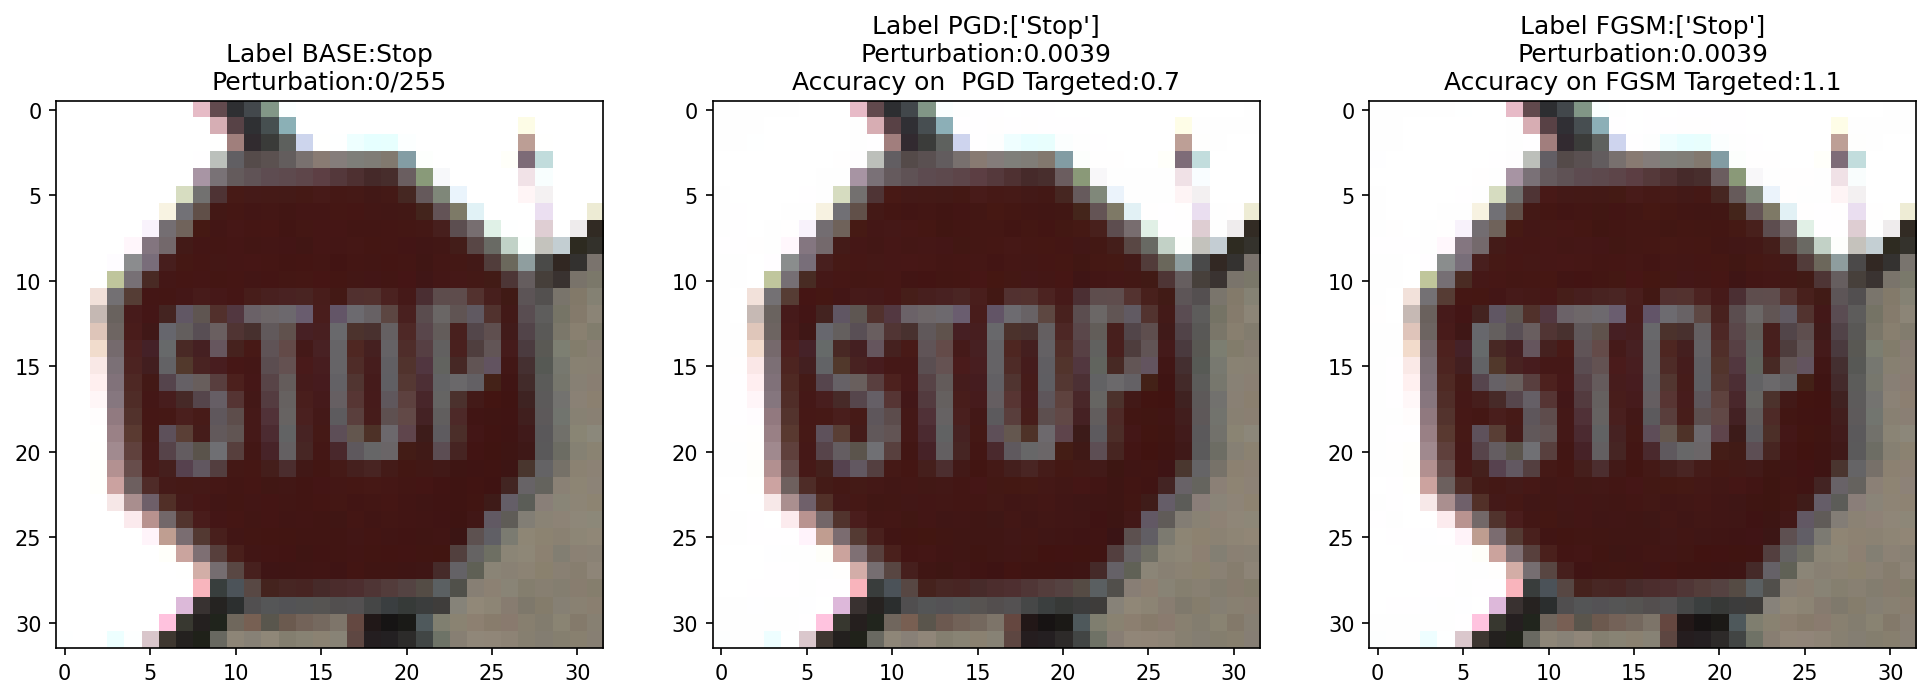

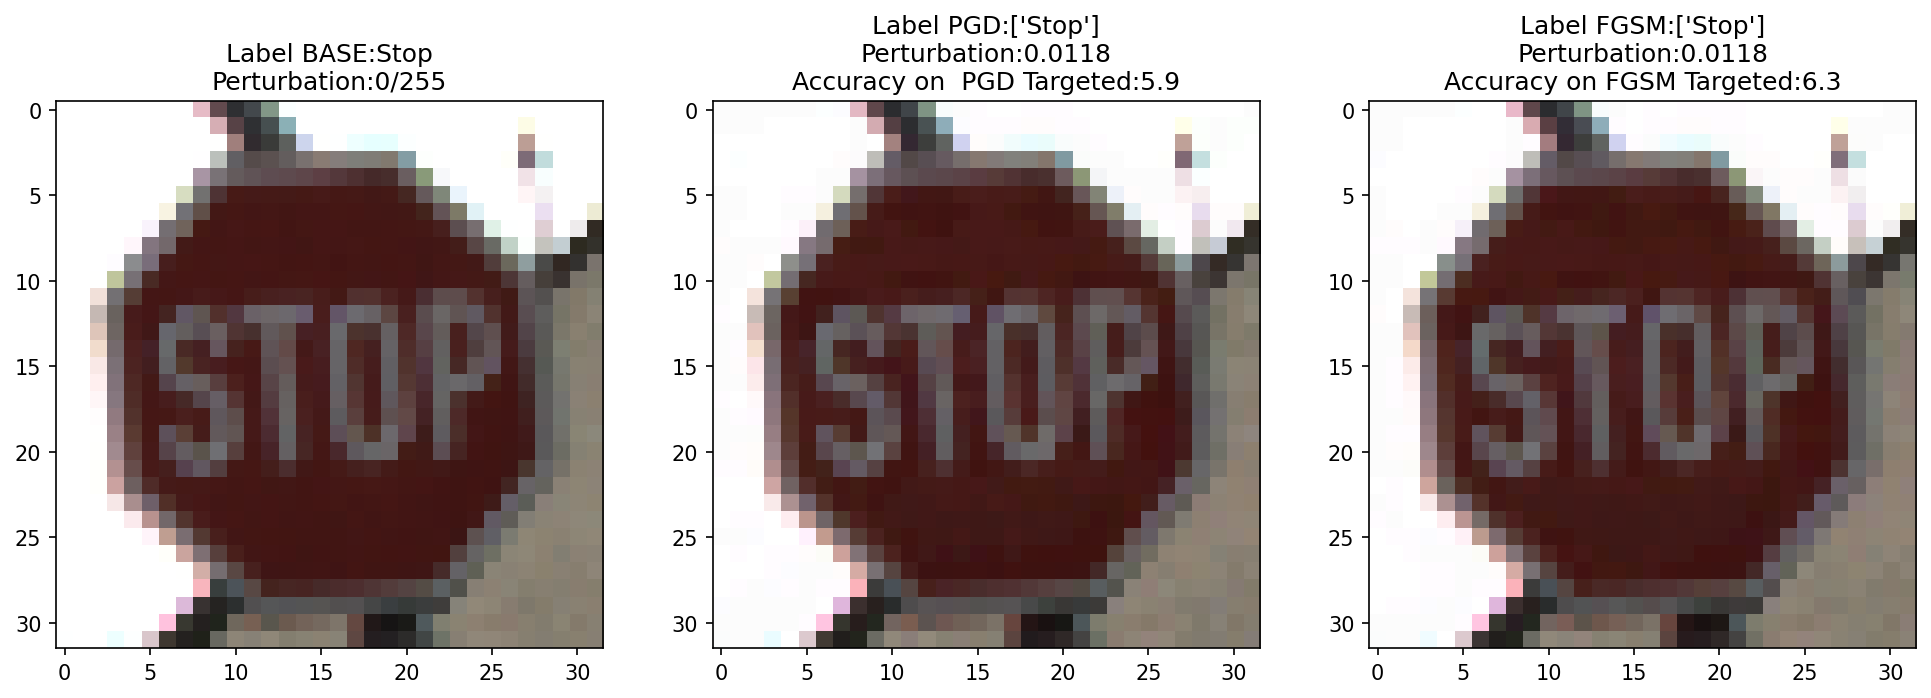

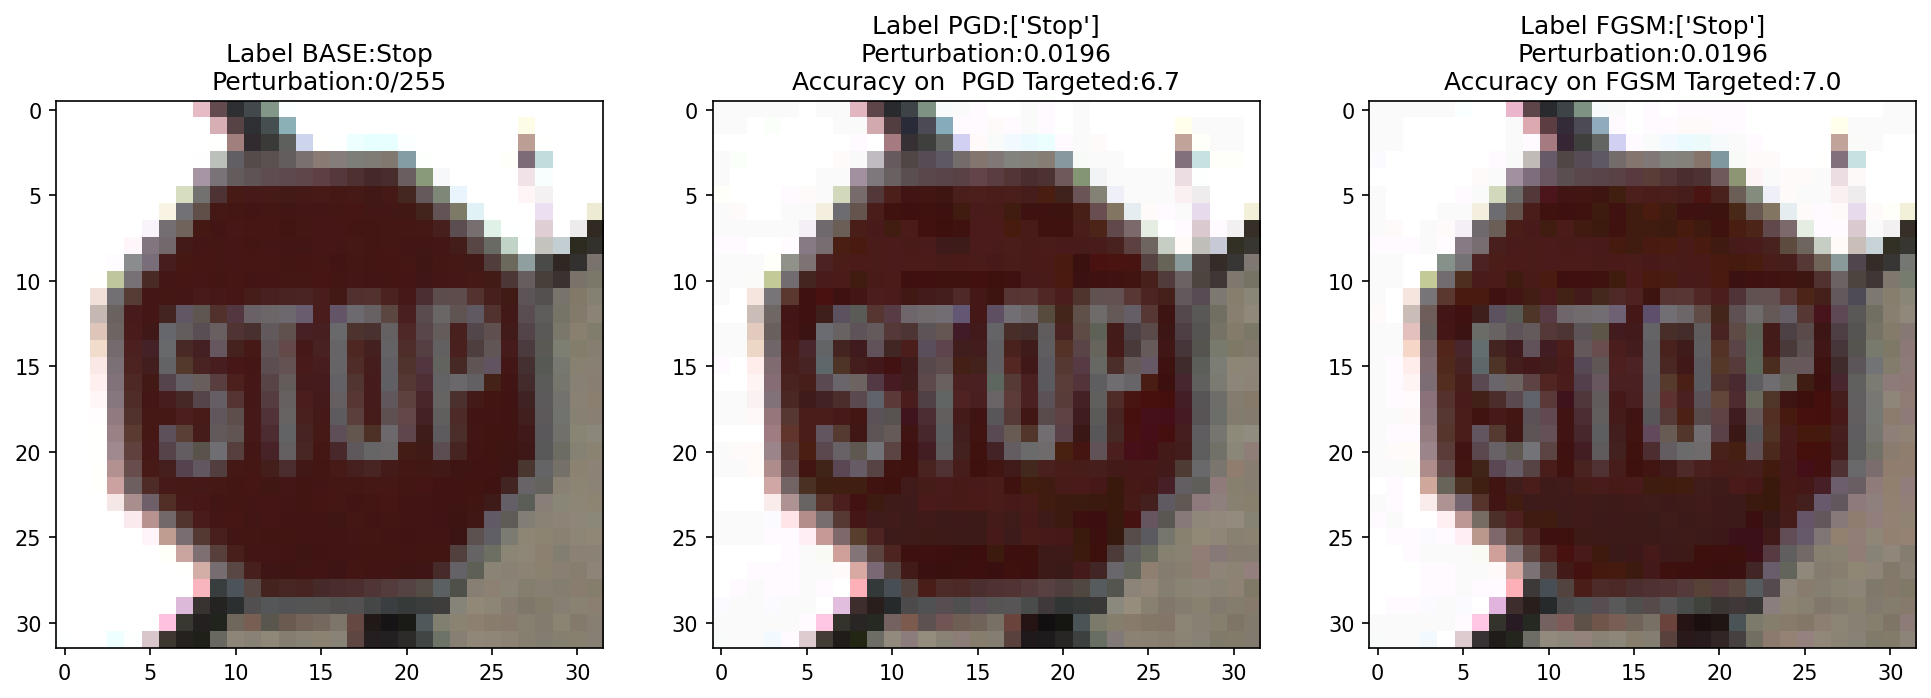

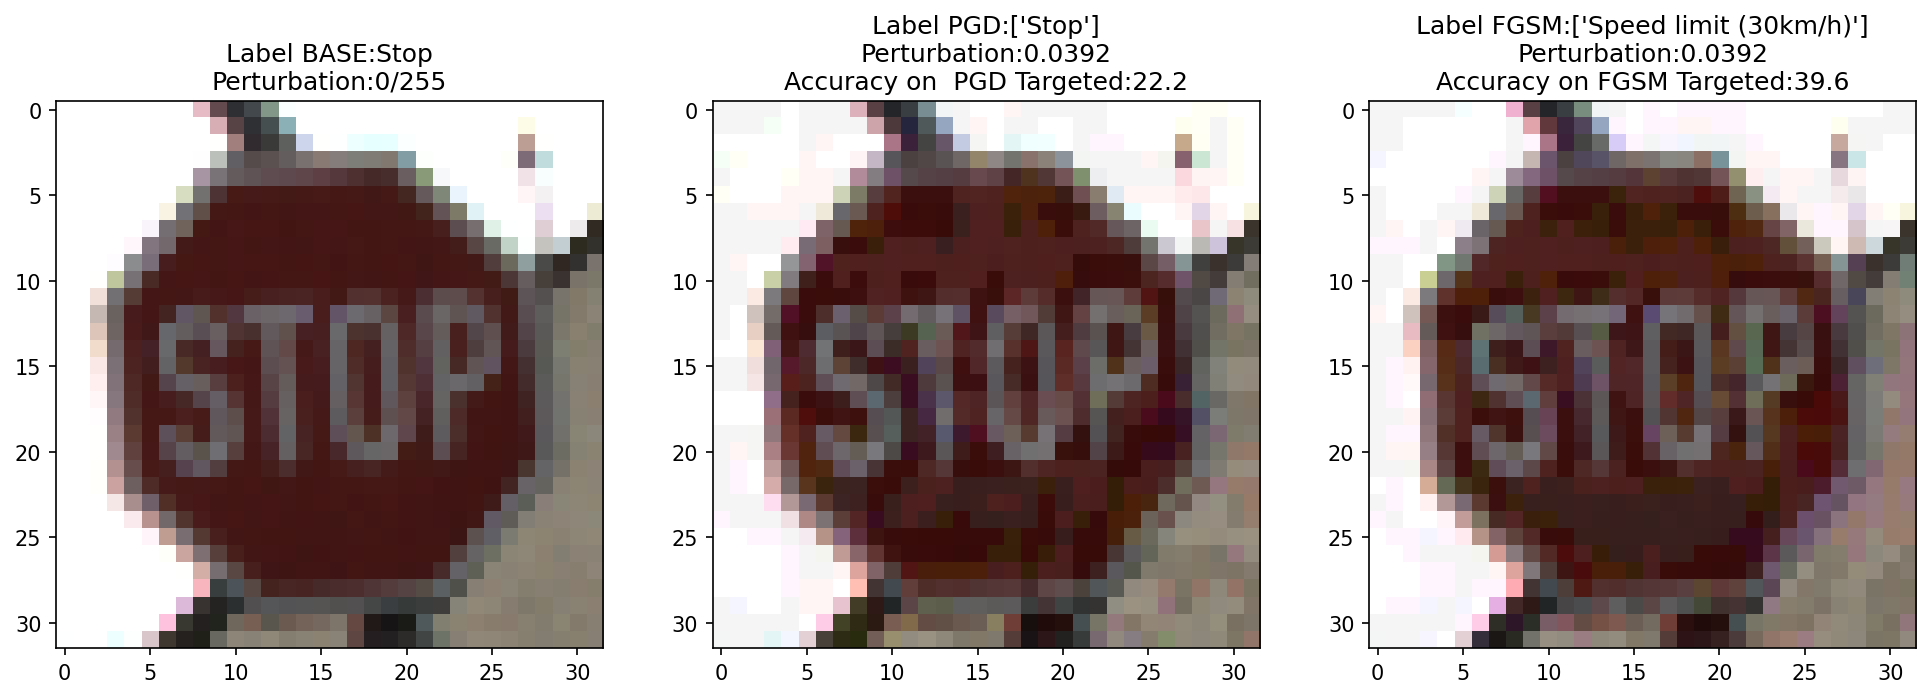

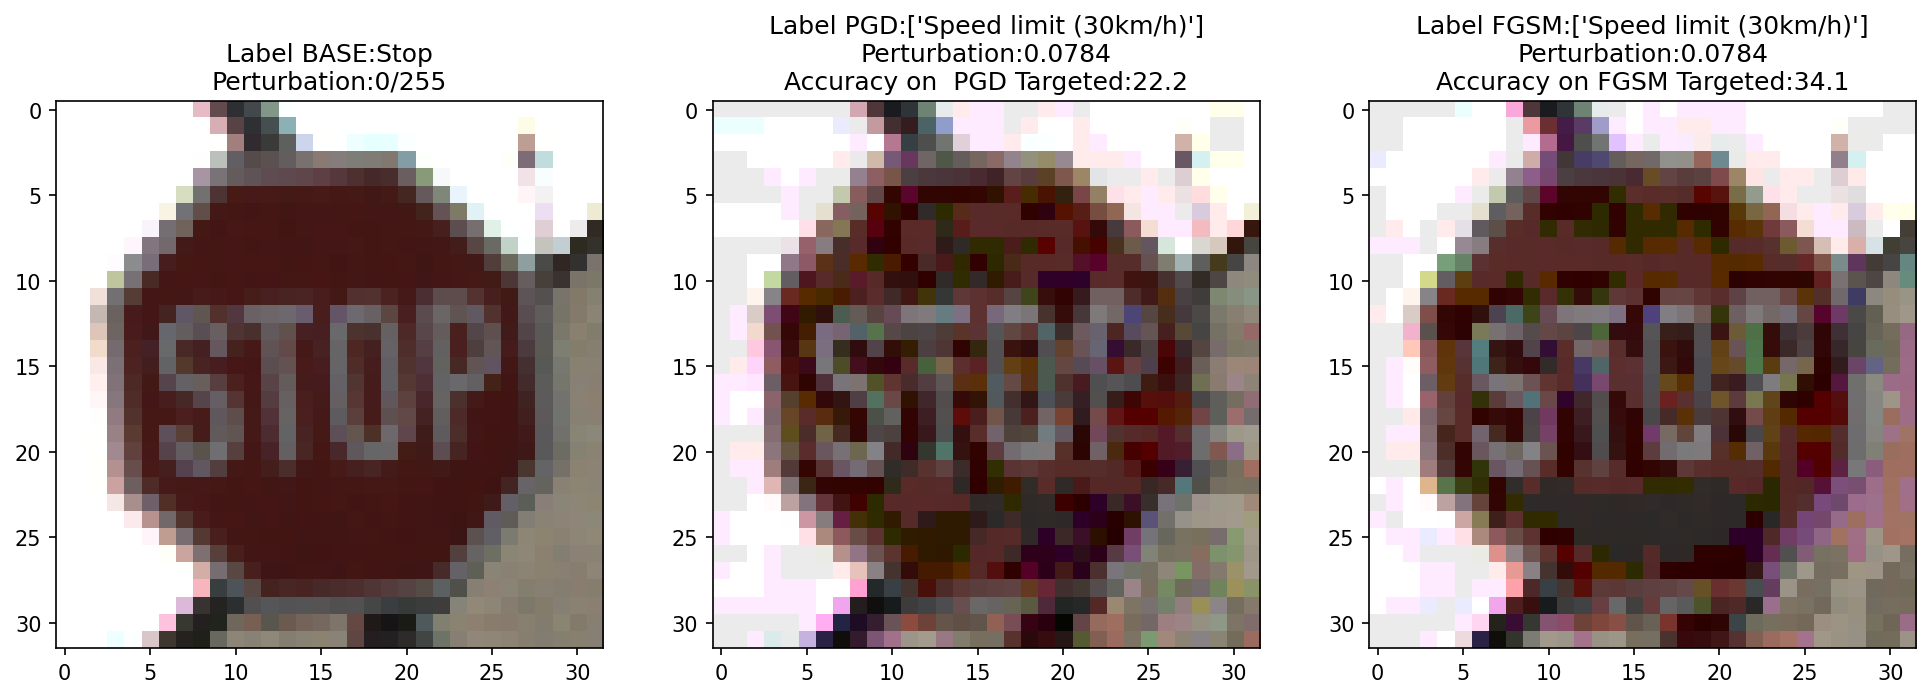

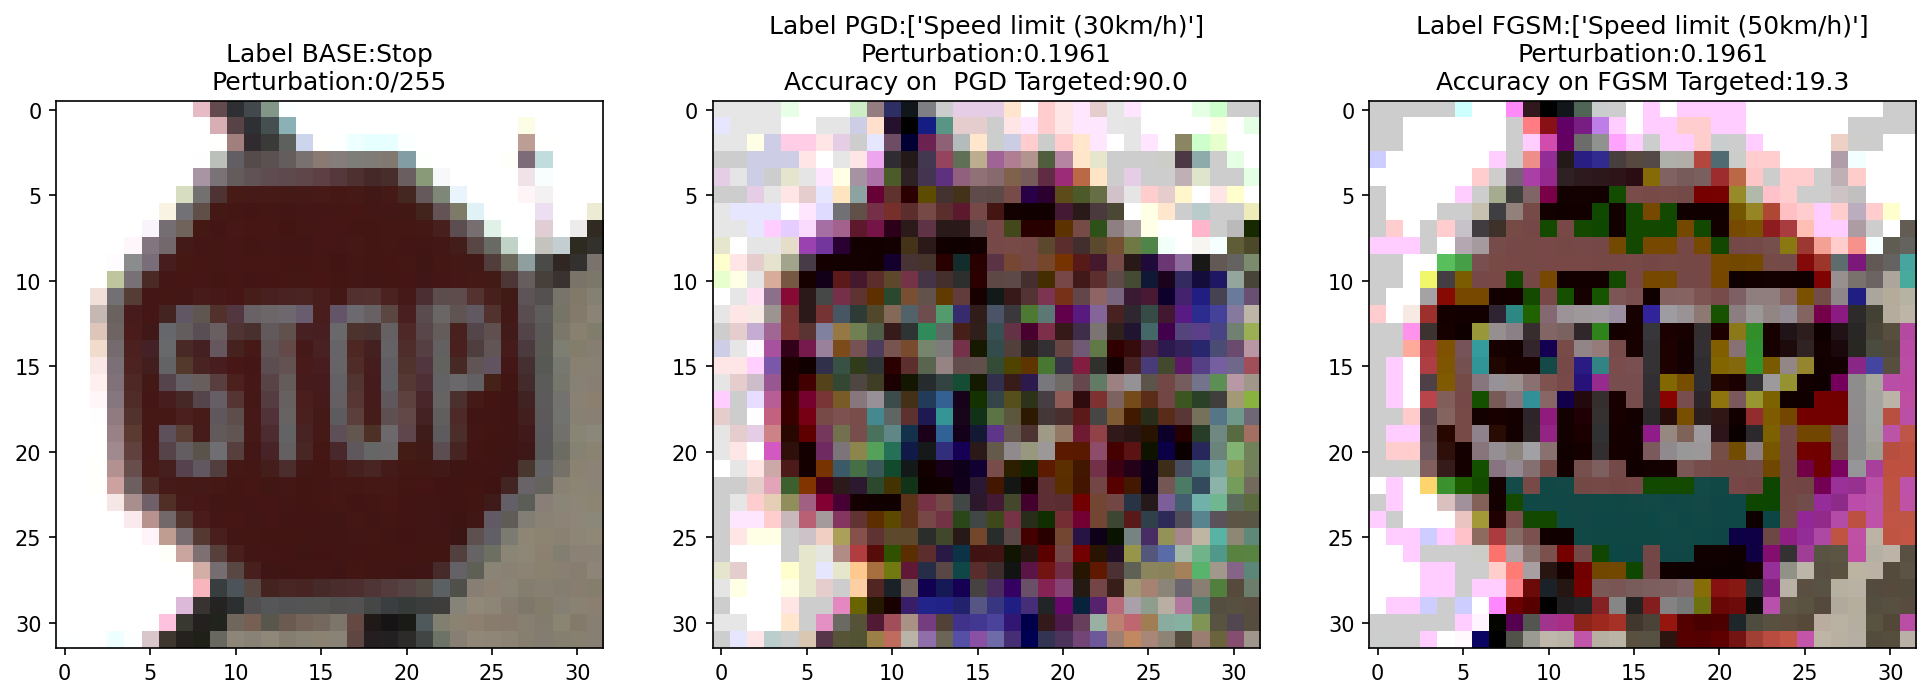

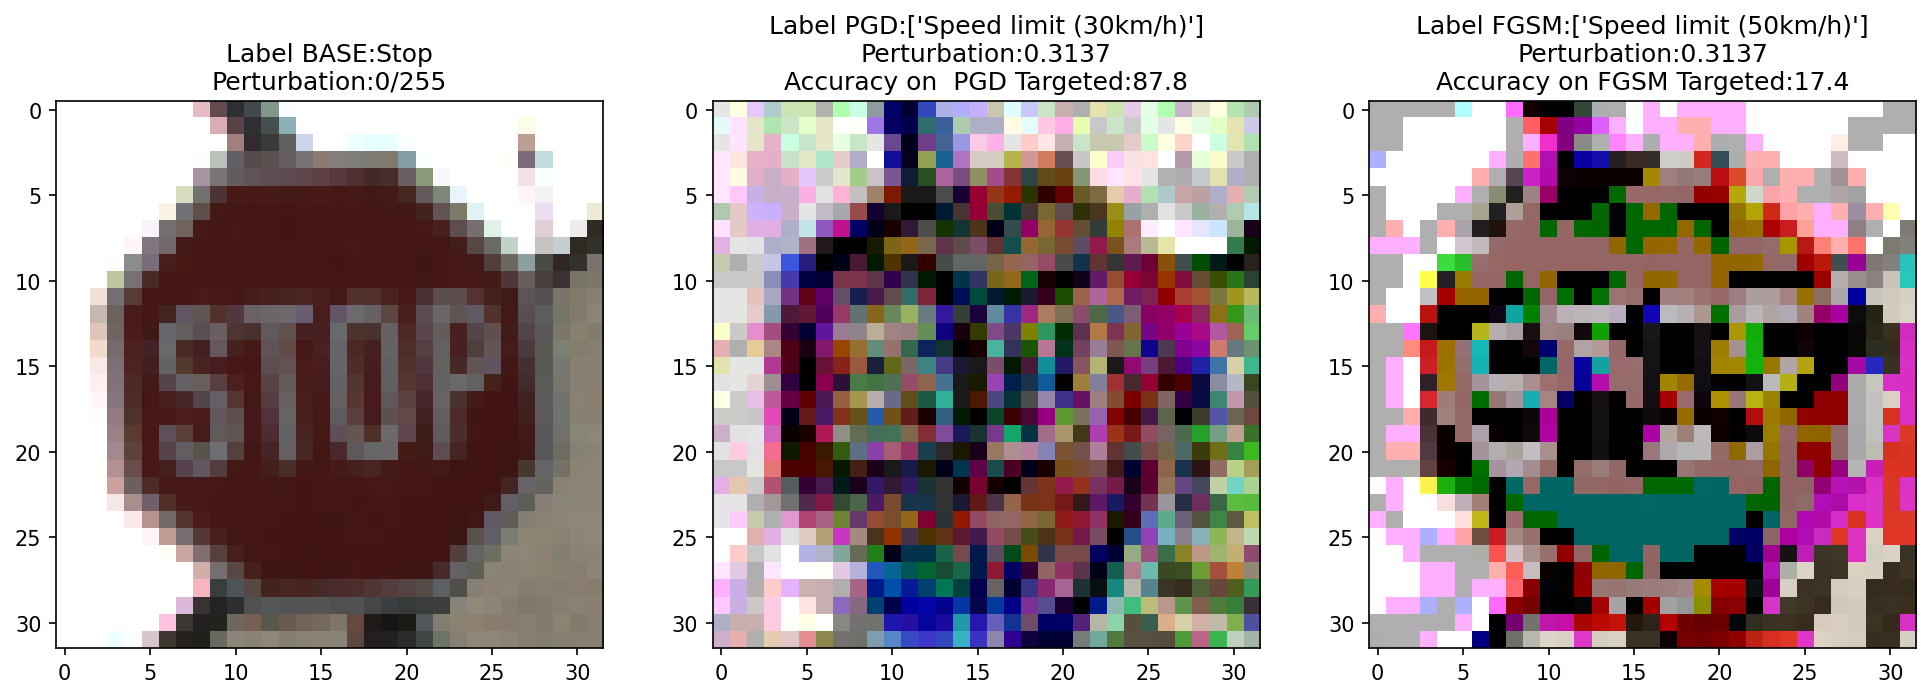

In [15]:
def plot_images(index):
    
    round((pgd_acc_list[i] * 100),1)
    
    plt.figure(figsize=(16, 16), dpi=150)
    #plot unperturbed images
    plt.subplot(1,3,1)
    plt.title('Label BASE:' + str(signnames[14] + '\n' + 'Perturbation:' + str(0) + '/255'))
    plt.imshow(imgs_stop_signs[0])
    #pgd
    plt.subplot(1,3,2)
    plt.title('Label PGD:' + str(signnames[pgd_pred_list[index]]) + '\n' + 'Perturbation:' + str(round(epsilon_list[index],4)) + 
              '\nAccuracy on  PGD Targeted:' + str(round((pgd_acc_list[i] * 100),1)))
    plt.imshow(image_list_pgd[index])
    #fgsm
    plt.subplot(1,3,3)
    plt.title('Label FGSM:' + str(signnames[fgsm_pred_list[index]]) + '\n' + 'Perturbation:' + str(round(epsilon_list[index],4)) + 
             '\nAccuracy on FGSM Targeted:' + str(round((fgsm_acc_list[i] * 100),1)))
    plt.imshow(image_list_fgsm[index])
    
    plt.show



    
for i in range(len(epsilon_list)):

    plot_images(i)
    #print('Accuracy on adversarial test data PGD Targeted: {:4.2f}%'.format(pgd_acc_list[i] * 100))
    #print('Accuracy on adversarial test data FGSM Targeted: {:4.2f}%'.format(fgsm_acc_list[i] * 100))

# Part 4: build a adversarial trainer defense.

Attacks are not the only part of adversarial machine learning. Defense come into play and are just as important. One defense is the adversarial trainer defense. The main idea behind this defense is that we give the trainer an attack object and an untrained model. The trainer will perturb part of our training data and feed it into the model so that it can potentially discern the different characteristics. Its important to note that the speed at which the model trains is dependant on the attack method used. This model is similar to doing data augmentation for your dataset.

The documentation for this defense can be found [here][train]

[//]: #

   [train]: <https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/trainer.html#adversarial-training>

In [16]:
from art.defences.trainer import AdversarialTrainer
model = build_model()



#create a classifier from our model. 

robustClassifier = KerasClassifier(model=model, clip_values=(0, 1))

#use the PGD attack to train our model at an E=5
#
attackPgd = ProjectedGradientDescent(estimator = robustClassifier,
                                         eps=(5/255),
                                         max_iter=40,
                                         batch_size=64)

#ratio determines how many adversarial samples make it into the training set.
#default is 0.5 might change later.
advTrainer = AdversarialTrainer(robustClassifier,attackPgd,ratio=.5)

print(labels_train_cat.shape)
advTrainer.fit(imgs_train, labels_train_cat, nb_epochs=25,batch_size=128)




(34799, 43)


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/25 [00:00<?, ?it/s]

# Testing the Robust classifier 

as we can see from the results, the adversarially trained model is more robust againts missclassificaitons compared to the non robust version. In our original model we saw a decrease in classification to around 60-70%. Our robust classifier was able to raise that to 85% for both FGSM and PGD

Deep fool and newton fool were also more robust even though their perturbation method is quite different than what PGD(which is what the trainer used). Overall it cant hurt your models to train using this type of defense. But you do have to consider time invested into training because it took well over an hour to train this model. without the trainer it takes about a minute.





In [ ]:

#save your model
#model.save(PROJECT_ROOT_DIR + MODEL_DIR +'adversarial_vgg.h5')



In [171]:


robustClassifier = load_model(PROJECT_ROOT_DIR + MODEL_DIR +'adversarial_vgg.h5')

imgs_adv_fgsm = fgsm_attack(8,classifier,imgs_adv,False)
imgs_adv_pgd = pgd_attack(8,classifier,imgs_adv,False)

#Clean training images
print_classification_acc(robustClassifier,"Clean Training Set",imgs_train,labels_train_cat)
#Clean testing images
print_classification_acc(robustClassifier,"Clean Testing Set",imgs_test,labels_test_cat)
#FGSM attacked images
print_classification_acc(robustClassifier,"FGSM Testing Set",imgs_adv_fgsm,labels_adv_cat)
#PGD attacked images
print_classification_acc(robustClassifier,"PGD Testing Set",imgs_adv_pgd,labels_adv_cat)
#FGSM attacked images
print_classification_acc(robustClassifier,"DeepFool Testing Set",imgs_adv_DeepFool,labels_adv_cat)
#PGD attacked images
print_classification_acc(robustClassifier,"Newton Fool Testing Set",imgs_adv_NewtonFool,labels_adv_cat)
    


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Jacob\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Clean Training Set Classification
Correctly Classified: 34770
Incorrectly Classified: 29
Percent Correct Classified: 99.91666427196184%

Clean Testing Set Classification
Correctly Classified: 12170
Incorrectly Classified: 460
Percent Correct Classified: 96.35787806809184%

FGSM Testing Set Classification
Correctly Classified: 842
Incorrectly Classified: 158
Percent Correct Classified: 84.2%

PGD Testing Set Classification
Correctly Classified: 854
Incorrectly Classified: 146
Percent Correct Classified: 85.39999999999999%

DeepFool Testing Set Classification
Correctly Classified: 521
Incorrectly Classified: 479
Percent Correct Classified: 52.1%

Newton Fool Testing Set Classification
Correctly Classified: 821
Incorrectly Classified: 179
Percent Correct Classified: 82.1%

